**Notebook 3** (v4)

Paso de capa Bronze a capa Silver

Dataset: **2023/01**

Objetivos del presente notebook:
- Estudio de las variables
- Visualización de las variables

Versiones:
- v1: no me convence mi nueva estrategia de hacer el estudio de valores a cero, nulos, outliers..., variable a variable
- v2: vuelvo a hacerlo en bloques: primero estudiar todas las variables, luego visualizar todas, luego valores a cero de todas, etc.; además, separo los datasets en notebooks diferentes -> error en v2: estoy incluyendo partes de la capa Silver
- v3: quito de v2 lo que corresponde a la capa Silver
- v4: limpieza de v3; acabado

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew

from pyspark.sql import SparkSession, DataFrame

from pyspark.sql.functions import (
    sum as spark_sum,
    min as spark_min,
    max as spark_max,
    count, col, when, isnan, isnull, mean, stddev, desc, asc,
    date_format, to_date, isnotnull, date_trunc, percentile_approx, lit
)

from pyspark.sql.types import *
from pyspark.sql import functions as F

from datetime import datetime

from google.colab import drive

import os
import re
import time
import sys

In [2]:
# enlace de autorización manual de acceso a Google Drive
'''
from google.colab import auth

print("Ve a este enlace para autorizar manualmente:")
auth.authenticate_user()
'''
print("Usar cuando se produzca algún error al montar Google Drive")

Usar cuando se produzca algún error al montar Google Drive


In [3]:
# monta Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# crea la estructura de directorios

# configuración de paths
PROJECT_ROOT = "/content/drive/MyDrive/taxi_project"
BRONZE_DIR = f"{PROJECT_ROOT}/bronze"
METADATA_DIR = f"{PROJECT_ROOT}/metadata"

# ruta de la capa Bronze
BRONZE_PATH = f"{BRONZE_DIR}/taxi_data"

# crea directorios si no existen
for path in [BRONZE_DIR, METADATA_DIR]:
    os.makedirs(path, exist_ok=True)

In [5]:
# setup para Spark en Google Colab

# instala Java si no está
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null

# fija JAVA_HOME
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

# asegura versión compatible de PySpark
!pip install -q pyspark==3.5.1

In [6]:
# configuración optimizada de Spark para Colab
'''
spark.driver.memory: asigna GB al proceso driver (máquina local actúa como driver y ejecutor)

spark.driver.maxResultSize: límite en GB de resultados que pueden ser devueltos al driver desde los executors;
evita que el driver se quede sin memoria

spark.executor.memory: memoria de los ejecutores (en local es el mismo proceso, pero influye en el planificador)

spark.sql.adaptive.enabled: activa el Adaptative Query Execution (AQE), ajuste dinámico del plan de ejecución
en tiempo de ejecución

spark.sql.adaptive.coalescePartitions.enabled: permite a AQE reducir el número de particiones en tiempo
de ejecución (mejor rendimiento si hay particiones vacías o desbalanceadas)

spark.sql.execution.arrow.pyspark.enabled: activa el uso de Apache Arrow para optimizar la conversión
entre dataframes de Spark y Pandas
'''

spark = SparkSession.builder \
    .appName("NYC-Taxi-Ingesta") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.executor.memory", "2g") \
	  .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
	  .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print(f"✅ Spark inicializado - Version: {spark.version}")

✅ Spark inicializado - Version: 3.5.1


# **Acceso a los datos**

In [7]:
def get_bronze_dataset_paths(bronze_root):
    """
    Devuelve todas las rutas individuales de datasets en la capa Bronze.

    Args:
        bronze_root (str): Ruta raíz de la capa Bronze.

    Returns:
        list: Lista de rutas individuales de datasets.
    """
    parquet_dirs = []
    for root, _, files in os.walk(bronze_root):
        if any(f.endswith(".parquet") for f in files):
            parquet_dirs.append(root)
    return sorted(parquet_dirs)

In [8]:
def extract_year_month_from_hive_partition(path):
    """
    Extrae año y mes de la estructura de particiones de Hive.

    Args:
        path (str): Ruta del dataset con estructura ingestion_year=YYYY/ingestion_month=MM

    Returns:
        tuple: (año, mes) o (None, None) si no se puede extraer
    """
    # busca patrones de partición de Hive en la ruta completa
    year_pattern = r'ingestion_year=(\d{4})'
    month_pattern = r'ingestion_month=(\d{1,2})'

    year_match = re.search(year_pattern, path)
    month_match = re.search(month_pattern, path)

    if year_match and month_match:
        year = int(year_match.group(1))
        month = int(month_match.group(1))

        # valida que el mes esté en rango válido
        if 1 <= month <= 12:
            return year, month

    return None, None

In [9]:
def format_date_info(year, month):
    """
    Formatea la información de fecha para mostrar.

    Args:
        year (int): Año
        month (int): Mes

    Returns:
        str: Fecha formateada
    """
    if year and month:
        try:
            # crea objeto datetime para obtener el nombre del mes
            date_obj = datetime(year, month, 1)
            month_names_es = {
                1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril',
                5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto',
                9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
            }
            return f"{year}-{month:02d} ({month_names_es[month]} {year})"
        except ValueError:
            return f"{year}-{month:02d}"
    return "Fecha no identificada"

In [10]:
# lista de datasets disponibles
bronze_datasets = get_bronze_dataset_paths(BRONZE_PATH)

print(f"Total de datasets encontrados: {len(bronze_datasets)}")

# muestra mes y año de los datos de cada dataset
for i, path in enumerate(bronze_datasets):

    year_bronze, month_bronze = extract_year_month_from_hive_partition(path)
    date_info = format_date_info(year_bronze, month_bronze)

    print(f"{i:2d}: {date_info:<25}")

Total de datasets encontrados: 3
 0: 2023-01 (Enero 2023)     
 1: 2023-02 (Febrero 2023)   
 2: 2023-03 (Marzo 2023)     


# **Funciones auxiliares**

- **Carga de datos**

In [11]:
def basic_process_dataset(current_dataset_index, bronze_datasets):
  """
  Carga un dataset en Spark y realiza una exploración básica.

  Args:
      current_dataset_index (int): Índice del dataset actual en la lista.
      bronze_datasets (list): Lista de rutas de datasets en la capa Bronze.

  Returns:
      tuple: la ruta del dataset, su nombre y el DataFrame cargado.
  """
  # comprueba que queden datasets pendientes de procesar
  if current_dataset_index < len(bronze_datasets):
    # ruta y nombre del dataset actual
    dataset_path = bronze_datasets[current_dataset_index]
    dataset_name = os.path.basename(dataset_path)

    print(f"=== Dataset {current_dataset_index}: {dataset_name} ===")

    # carga el dataset
    ds = spark.read.parquet(dataset_path)

    # exploración básica
    print(f"Total de registros: {ds.count():,}")
    print(f"\nRuta: {dataset_path}")

    print("\nEsquema:")
    ds.printSchema()

    print("\nPrimeras 5 filas:")
    ds.show(5)

    ## registros duplicados
    print("\n=== VERIFICACIÓN DE DUPLICADOS ===")

    # total de registros
    total_registros = ds.count()
    # registros únicos (eliminando duplicados)
    registros_unicos = ds.distinct().count()

    # determina si hay duplicados
    tiene_duplicados = total_registros > registros_unicos
    if tiene_duplicados:
        duplicados_count = total_registros - registros_unicos
        print(f"Número de registros duplicados: {duplicados_count}")
    else:
        print("No existen registros duplicados")

    ## registros con todos sus valores nulos
    print("\n=== REGISTROS CON TODOS SUS VALORES NULOS ===")

    # agrega una columna que cuenta las columnas no nulas por fila
    ds_con_conteo = ds.withColumn(
        "columnas_no_nulas",
        sum([when(~col(c).isNull(), 1).otherwise(0) for c in ds.columns])
    )

    # cuenta las filas donde todas las columnas son nulas (columnas_no_nulas = 0)
    registros_nulos_alt = ds_con_conteo.filter(col("columnas_no_nulas") == 0).count()
    print(f"Registros completamente nulos: {registros_nulos_alt}")

    ## valores nulos
    print("\n=== VALORES NULOS POR VARIABLE ===")

    # inicializa lista de resultados
    null_counts = []
    # recorre las columnas
    for col_name in ds.columns:

        # cuenta valores nulos de la columna actual
        null_count = ds.filter(col(col_name).isNull()).count()

        ## calcula el porcentaje de nulos como un float estándar de Python
        # número total de registros del Dataframe
        total_records = ds.count()
        if total_records > 0:
            # hay registros
            null_percentage = (null_count / total_records) * 100
        else:
            # no hay registros: evita división por cero
            null_percentage = 0.0

        # diccionario nombre columna, número nulos y porcentaje nulos
        null_counts.append({
            'column': col_name,
            'null_count': null_count,
            # función round incorporada de Python
            'null_percentage': __builtins__.round(null_percentage, 2)
        })

    # convierte la lista de resultados en Dataframe de Pandas
    null_ds = pd.DataFrame(null_counts)

    # muestra los resultados
    print(null_ds.to_string(index=False))

    # devuelve ruta, nombre y dataframe
    return dataset_path, dataset_name, ds

  else:
    print("Ya están procesados todos los datasets")

- **Análisis de datos**

In [12]:
def show_column_spark(ds, col_name):
    """
    Muestra una descripción de la columna del Dataframe de Spark recibido.

    Args:
        ds: Dataframe de PySpark
        col_name: str, nombre de la columna
    """
    # validación
    if col_name not in ds.columns:
        raise ValueError(f"La columna '{col_name}' no está en el DataFrame.")

    # tipo de dato
    col_type = dict(ds.dtypes)[col_name]
    print(f"Tipo de dato: {col_type}")

    # número de registros
    total_rows = ds.count()
    print(f"Total de registros: {total_rows:,}")

    # frecuencia de valores
    print("\n")
    print("-" * 15, "Frecuencia de valores", "-" * 15)
    ds.groupBy(col_name).count().orderBy(desc("count")).show(20)

    # valores únicos
    print("-" * 50)
    unique_count = ds.select(col_name).distinct().count()
    print(f"Valores únicos: {unique_count:,}")

    # columnas numéricas: valores a cero y valores negativos
    if col_type in ['int', 'bigint', 'float', 'double', 'decimal']:
        zero_count = ds.select(count(when(col(col_name) == 0, col_name))).collect()[0][0]
        print(f"Valores a cero: {zero_count:,} ({zero_count/total_rows*100:.2f}%)")

        # valores negativos
        negative_count = ds.select(count(when(col(col_name) < 0, col_name))).collect()[0][0]
        print(f"Valores negativos: {negative_count:,} ({negative_count/total_rows*100:.2f}%)")

        # estadísticas descriptivas para numéricas
        print("-" * 50)
        print("Estadísticas descriptivas:")
        ds.select(col_name).describe().show()

    # valores nulos
    null_count = ds.filter(col(col_name).isNull()).count()
    print("-" * 50)
    print(f"Valores nulos: {null_count:,} ({null_count/total_rows*100:.2f}%)")

    print("-" * 50)

    # columnas de fecha: primera y última fecha
    if col_type in ['date', 'timestamp', 'timestamp_ntz']:
        # Obtener primera y última fecha (excluyendo nulos)
        date_stats = ds.filter(col(col_name).isNotNull()).agg(
            spark_min(col(col_name)).alias('fecha_minima'),
            spark_max(col(col_name)).alias('fecha_maxima')
        ).collect()[0]

        primera_fecha = date_stats['fecha_minima']
        ultima_fecha = date_stats['fecha_maxima']

        print(f"Primera fecha: {primera_fecha}")
        print(f"Última fecha: {ultima_fecha}")

In [13]:
'''
v2
'''
def analyze_date_ranges(df, col_name, start_date, end_date, show_outside_dates=False):
    """
    Muestra el número y porcentaje de registros fuera del rango de fechas,
    y opcionalmente el desglose diario antes y después.

    Args:
        df: DataFrame de PySpark
        col_name: str, nombre de la columna de fecha
        start_date: str, fecha inicial (inclusive) en formato 'YYYY-MM-DD'
        end_date: str, fecha final (inclusive) en formato 'YYYY-MM-DD'
        show_outside_dates: bool, si True, muestra desgloses diarios fuera del rango
    """
    # comprueba que la columna sea de tipo timestamp
    df = df.withColumn(col_name, col(col_name).cast(TimestampType()))

    # crea una columna auxiliar con solo la fecha (sin la hora)
    df_with_date = df.withColumn("date_only", to_date(col(col_name)))

    # convierte las fechas de string a tipo date para comparación consistente
    start_date_typed = lit(start_date).cast("date")
    end_date_typed = lit(end_date).cast("date")

    # filtra registros fuera del rango de fechas (sin considerar la hora)
    before_df = df_with_date.filter(col("date_only") < start_date_typed)
    after_df = df_with_date.filter(col("date_only") > end_date_typed)

    # cuenta registros
    total_count = df.count()
    before_count = before_df.count()
    after_count = after_df.count()

    # calcula porcentajes
    before_pct = (before_count / total_count) * 100 if total_count > 0 else 0
    after_pct = (after_count / total_count) * 100 if total_count > 0 else 0

    # muestra resultados
    print(f"Total registros: {total_count:,}")
    print(f"Antes de {start_date}: {before_count:,} ({before_pct:.2f}%)")
    print(f"Después de {end_date}: {after_count:,} ({after_pct:.2f}%)")

    # comprueba si tiene que mostrar los desgloses diarios
    if show_outside_dates:

        # anteriores al rango
        if before_count > 0:
            print(f"\nDistribución diaria antes de {start_date}:")

            (before_df
             .groupBy("date_only")
             .agg(count("*").alias("registros"))
             .orderBy("date_only")
             # muestra hasta 30 días
             .show(30, truncate=False)
            )

        # posteriores al rango
        if after_count > 0:
            print(f"\nDistribución diaria después de {end_date}:")

            (after_df
             .groupBy("date_only")
             .agg(count("*").alias("registros"))
             .orderBy("date_only")
             # muestra hasta 30 días
             .show(30, truncate=False)
             )

- **Visualización de datos**

In [14]:
def analyze_categorical_variable_spark(
    ds, variable, fecha_col=None, frecuencia='W', top_n=10, filtro=None
):
    """
    Muestra análisis de una variable categórica de un DataFrame de Spark.

    Args:
        ds: DataFrame de Spark
        variable: str, nombre de la variable categórica
        fecha_col: str, nombre de la variable de fecha (si existe, para análisis temporal)
        frecuencia: str, intervalo de tiempo para el análisis temporal
            D: diario; W: semanal; M: mensual
        top_n: int, número de categorías más frecuentes a mostrar en gráficos
        filtro: str, expresión SQL opcional para filtrar la variable a analizar
            Ejemplo: "IS NOT NULL", "= 'valor'", "IN ('val1', 'val2')"

    Returns:
        diccionario con estadísticas de la variable categórica
            {'total_registros', 'categorias_unicas', 'categoria_mas_frecuente',
            'frecuencia_maxima', 'porcentaje_maximo', 'categoria_menos_frecuente',
            'frecuencia_minima', 'porcentaje_minimo', 'concentracion_top_n',
            'top_n_usado'}
    """
    resultado = {}

    # valida los datos recibidos
    if variable not in ds.columns:
        raise ValueError(f"La variable '{variable}' no está en el DataFrame.")
    if fecha_col and fecha_col not in ds.columns:
        raise ValueError(f"La columna de fecha '{fecha_col}' no está en el DataFrame.")

    # aplica filtro si se especifica
    ds_filtrado = ds
    if filtro:
        try:
            # construye la expresión de filtrado
            filtro_completo = f"{variable} {filtro}"
            ds_filtrado = ds.filter[filtro_completo]

            total_original = ds.count()
            total_filtrado = ds_filtrado.count()

            print(f"Filtro aplicado: {filtro_completo}")
            print(f"Registros después del filtrado: {total_filtrado:,} (de {total_original:,})")
            print()
        except Exception as e:
            raise ValueError(f"Error al aplicar el filtro '{filtro}': {str(e)}")

    # filtra nulos y cuenta registros totales
    ds_sin_nulos = ds_filtrado.filter(col(variable).isNotNull())
    total_registros = ds_sin_nulos.count()

    if total_registros == 0:
        print("ADVERTENCIA: No quedan datos después de aplicar el filtro ",
             f"{variable} {filtro}")
        return {'total_registros': 0, 'categorias_unicas': 0}

    # tabla de frecuencias (sin categorías vacías en caso de filtrado)
    freq_spark = (
        ds_sin_nulos
        .groupBy(variable)
        .agg(count("*").alias("frecuencia"))
        .orderBy(desc("frecuencia"))
    )

    # convierte a Pandas para facilitar el análisis y la visualización
    freq_pandas = freq_spark.toPandas()
    freq_pandas = freq_pandas.set_index(variable)['frecuencia']

    # calcula porcentajes
    freq_porcentajes = (freq_pandas / total_registros * 100).sort_values(ascending=False)

    # estadísticas básicas
    resultado['total_registros'] = total_registros
    resultado['categorias_unicas'] = len(freq_pandas)
    if len(freq_pandas) > 0:
        # hay datos después del filtrado
        resultado['categoria_mas_frecuente'] = freq_pandas.index[0]
        resultado['frecuencia_maxima'] = freq_pandas.iloc[0]
        resultado['porcentaje_maximo'] = freq_porcentajes.iloc[0]
        resultado['categoria_menos_frecuente'] = freq_pandas.index[-1]
        resultado['frecuencia_minima'] = freq_pandas.iloc[-1]
        resultado['porcentaje_minimo'] = freq_porcentajes.iloc[-1]
        # concentración (porcentaje acumulado de las top_n categorías)
        top_categorias = freq_porcentajes.head(min(top_n, len(freq_porcentajes)))
        resultado['concentracion_top_n'] = top_categorias.sum()
        resultado['top_n_usado'] = len(top_categorias)
    else:
        # no quedan datos después del filtrado
        print("ADVERTENCIA: No quedan datos después de aplicar el filtro ",
             f"{variable} {filtro}")
        return resultado

    # gráfico de barras (top_n categorías)
    plt.figure(figsize=(12, 6))
    top_freq = freq_pandas.head(top_n)
    plt.bar(range(len(top_freq)), top_freq.values, color='skyblue', alpha=0.7)
    titulo_grafico = f"Top {min(top_n, len(freq_pandas))} "
    titulo_grafico += f"categorías más frecuentes - {variable}"
    if filtro:
        titulo_grafico += f" (filtro: {variable} {filtro})"
    plt.title(titulo_grafico)
    plt.xlabel("Categorías")
    plt.ylabel("Frecuencia")
    plt.xticks(range(len(top_freq)), [str(x) for x in top_freq.index], rotation=45, ha='right')

    # añade valores sobre las barras
    for i, v in enumerate(top_freq.values):
        plt.text(i, v + max(top_freq.values) * 0.01, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # gráfico de sectores
    if len(freq_pandas) <= 8:
        # pocas categorías: muestra todas
        plt.figure(figsize=(8, 8))
        plt.pie(freq_pandas.values, labels=[str(x) for x in freq_pandas.index],
                autopct='%1.1f%%', startangle=90)
        titulo_pie = f"Distribución de {variable}"
        if filtro:
            titulo_pie += f" (filtro: {filtro})"
        plt.title(titulo_pie)
        plt.axis("equal")
        plt.show()
    else:
        # muchas categorías: muestra sólo las top_n y agrupa el resto
        plt.figure(figsize=(8, 8))
        top = freq_pandas.head(top_n)
        otros = freq_pandas.iloc[top_n:].sum()
        if otros > 0:
            valores = list(top.values) + [otros]
            etiquetas = [str(x) for x in top.index] + ['Otros']
        else:
            valores = top.values
            etiquetas = [str(x) for x in top.index] + ['Otros']
        plt.pie(valores, labels=etiquetas, autopct='%1.1f%%', startangle=90)
        titulo_pie = f"Distribución de {variable} (Top {top_n} + Otros)"
        if filtro:
            titulo_pie += f" (filtro: {filtro})"
        plt.title(titulo_pie)
        plt.axis("equal")
        plt.show()

    # análisis temporal (si se indica columna de fecha)
    if fecha_col:

        # dataframe con fechas
        ds_temp = (ds_sin_nulos
                   .select(fecha_col, variable)
                   .filter(col(fecha_col).isNotNull())
        )

        # configuración de frecuencia
        if frecuencia == 'D':
            fecha_truncada = date_trunc("day", col(fecha_col))
            frecuencia_txt = "día"
        elif frecuencia == 'W':
            fecha_truncada = date_trunc("week", col(fecha_col))
            frecuencia_txt = "semana"
        elif frecuencia == 'M':
            fecha_truncada = date_trunc("month", col(fecha_col))
            frecuencia_txt = "mes"
        else:
            print("*** Error en la frecuencia recibida ***")
            print(f"Sólo son válidos los valores D/W/M, pero se ha recibido {frecuencia}")
            return resultado

        # agrupa por periodo y categoría
        conteos_periodo_spark = (ds_temp
                                 .withColumn("periodo", fecha_truncada)
                                 .groupBy("periodo", variable)
                                 .agg(F.count("*").alias("conteo"))
                                 .orderBy("periodo")
        )

        # convierte a Pandas para visualización
        conteos_periodo_pandas = conteos_periodo_spark.toPandas()

        if not conteos_periodo_pandas.empty:
            # hay datos después del filtrado: crea tabla pivotada
            conteos_pivot = conteos_periodo_pandas.pivot_table(
                index='periodo', columns=variable, values='conteo', fill_value=0
            )

            # gráfico de evolución temporal (top_n categorías)
            plt.figure(figsize=(14, 8))
            top_cats_temporal = freq_pandas.head(top_n).index

            plotted_any = False

            for cat in top_cats_temporal:
                if str(cat) in conteos_pivot.columns:

                    serie_datos = conteos_pivot[str(cat)].fillna(0)
                    if serie_datos.sum() > 0:
                        # sólo grafica si hay datos
                        plt.plot(conteos_pivot.index, conteos_pivot[str(cat)],
                                 marker='o', label=str(cat), alpha=0.7, linewidth=2)
                    plotted_any = True

            if plotted_any:

                titulo_temporal = f"Evolución temporal de {variable} "
                titulo_temporal += f"(Top {top_n} categorías) por {frecuencia_txt}"
                if filtro:
                    titulo_temporal += f" (filtro: {filtro})"
                plt.title(titulo_temporal)
                plt.xlabel("Fecha")
                plt.ylabel(f"Conteo por {frecuencia_txt}")
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()

            else:
                print("No hay datos para mostrar en el gráfico de evolución temporal.")

            ## gráfico de barras apiladas
            plt.figure(figsize=(14, 8))
            top_cols = [str(cat) for cat in top_cats_temporal if str(cat) in conteos_pivot.columns]

            # comprueba que haya datos para graficar
            if top_cols and not conteos_pivot[top_cols].empty:
                # asegura que los datos sean numéricos
                datos_numericos = conteos_pivot[top_cols].fillna(0).astype(float)
                datos_numericos.plot(kind='bar', stacked=True, figsize=(14, 8), alpha=0.8)
                titulo_apiladas = f"Distribución de {variable} por {frecuencia_txt} "
                titulo_apiladas += f"(barras apiladas)"
                if filtro:
                    titulo_apiladas += f" (filtro: {filtro})"
                plt.title(titulo_apiladas)
                plt.xlabel("Fecha")
                plt.ylabel(f"Conteo por {frecuencia_txt}")
                plt.legend(title=variable, bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
            else:
                print("No hay datos para mostrar en el gráfico de barras apiladas.")

            # estadísticas adicionales para análisis temporal
            fechas_minmax = (ds_temp
                             .agg(spark_min(fecha_col).alias('fecha_min'),
                                  spark_max(fecha_col).alias('fecha_max'))
                             .collect()[0]
                             )
            resultado['periodos_analizados'] = len(conteos_pivot)
            resultado['fecha_inicio'] = fechas_minmax['fecha_min']
            resultado['fecha_fin'] = fechas_minmax['fecha_max']

        else:
            print("*** Error en la frecuencia recibida ***")
            print(f"Sólo son válidos los valores D/W/M, pero se ha recibido {frecuencia}")
            print()

    # muestra frecuencia de repetición de valores
    print("=" * 15, "Frecuencia de valores", "=" * 15)
    if filtro:
        print(f"Datos filtrados: {variable} {filtro}")
    for categoria, frecuencia in freq_pandas.items():
        print(f"{categoria}: {frecuencia}")

    # muestra resumen estadístico
    print("=" * 50)
    titulo_resumen = f"RESUMEN ESTADÍSTICO - {variable}"
    if filtro:
        titulo_resumen += f" (filtro: {filtro})"
    print(titulo_resumen)
    print("=" * 50)
    print(f"Total de registros: {resultado['total_registros']:,}")
    print(f"Categorías únicas: {resultado['categorias_unicas']:,}")

    if resultado['categorias_unicas'] > 0:
        print(f"Categoría más frecuente: '{resultado['categoria_mas_frecuente']}' ",
              f"({resultado['frecuencia_maxima']:,} veces, ",
              f"{resultado['porcentaje_maximo']:.1f}%)")
        print(f"Categoría menos frecuente: '{resultado['categoria_menos_frecuente']}' ",
              f"({resultado['frecuencia_minima']:,} veces, ",
              f"{resultado['porcentaje_minimo']:.1f}%)")
        print(f"Concentración {resultado['top_n_usado']} valores más repetidos: ",
              f"{resultado['concentracion_top_n']:.1f}% de los datos")

    if 'fecha_inicio' in resultado:
        print(f"Período analizado: {resultado['fecha_inicio']} ",
              f"a {resultado['fecha_fin']}")
        print(f"Períodos de {frecuencia_txt}: {resultado['periodos_analizados']:,}")

    return resultado

In [15]:
def analyze_datetime_variable_spark(
    ds, variable, frecuencia='M', top_n=10
):
    """
    Muestra análisis de una variable de fecha/datetime de un DataFrame de Spark.

    Args:
        ds: DataFrame de Spark
        variable: str, nombre de la variable datetime
        frecuencia: str, intervalo de tiempo para el análisis
            D: diario; W: semanal; M: mensual; Y: anual
        top_n: int, número de períodos más frecuentes a mostrar en algunos gráficos

    Returns:
        diccionario con estadísticas de la variable datetime
            {'total_registros', 'fecha_minima', 'fecha_maxima', 'rango_dias',
            'año_inicio', 'año_fin', 'rango_años', 'meses_unicos', 'años_unicos',
            'dia_semana_mas_frecuente', 'mes_mas_frecuente', 'año_mas_frecuente',
            'concentracion_temporal'}
    """
    resultado = {}

    # valida los datos recibidos
    if variable not in ds.columns:
        raise ValueError(f"La variable '{variable}' no está en el DataFrame.")

    # filtra valores no nulos y convierte a fecha si es necesario
    ds_clean = ds.filter(isnotnull(col(variable)))

    # asegura que la columna sea de tipo timestamp
    ds_clean = ds_clean.withColumn(variable, to_date(col(variable)))

    # estadísticas básicas
    estadisticas_basicas = ds_clean.agg(
        count(variable).alias('total'),
        spark_min(variable).alias('fecha_min'),
        spark_max(variable).alias('fecha_max')
    ).collect()[0]

    resultado['total_registros'] = estadisticas_basicas['total']
    resultado['fecha_minima'] = estadisticas_basicas['fecha_min']
    resultado['fecha_maxima'] = estadisticas_basicas['fecha_max']
    resultado['rango_dias'] = (estadisticas_basicas['fecha_max'] - estadisticas_basicas['fecha_min']).days
    resultado['año_inicio'] = estadisticas_basicas['fecha_min'].year
    resultado['año_fin'] = estadisticas_basicas['fecha_max'].year
    resultado['rango_años'] = resultado['año_fin'] - resultado['año_inicio']

    # análisis por componentes de fecha
    ds_componentes = ds_clean.withColumn("año", F.year(col(variable))) \
                       .withColumn("mes", F.month(col(variable))) \
                       .withColumn("dia_semana", F.dayofweek(col(variable)) - 1)   # 0: lunes

    resultado['años_unicos'] = ds_componentes.select('año').distinct().count()
    resultado['meses_unicos'] = ds_componentes.select('mes').distinct().count()

    # frecuencias por año
    freq_años = ds_componentes.groupBy('año') \
        .count() \
        .orderBy('año') \
        .collect()

    # frecuencias por mes
    freq_meses = ds_componentes.groupBy('mes') \
        .count() \
        .orderBy('mes') \
        .collect()

    # frecuencias por día de la semana
    freq_dias_semana = ds_componentes.groupBy('dia_semana') \
        .count() \
        .orderBy('dia_semana') \
        .collect()

    # más frecuentes
    año_mas_freq = ds_componentes.groupBy('año') \
        .count() \
        .orderBy(desc('count')) \
        .collect()[0]['año']
    mes_mas_freq = ds_componentes.groupBy('mes') \
        .count() \
        .orderBy(desc('count')) \
        .collect()[0]['mes']
    dia_mas_freq = ds_componentes.groupBy('dia_semana') \
        .count() \
        .orderBy(desc('count')) \
        .collect()[0]['dia_semana']

    resultado['año_mas_frecuente'] = año_mas_freq
    resultado['mes_mas_frecuente'] = mes_mas_freq
    resultado['dia_semana_mas_frecuente'] = dia_mas_freq

    # nombres de meses y días
    nombres_meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                     'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
    nombres_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

    # gráfico de distribución por años
    plt.figure(figsize=(12, 6))

    años_data = [ (row['año'], row['count']) for row in freq_años]
    años_x, años_y = zip(*años_data) if años_data else ([], [])
    plt.bar(años_x, años_y, color='lightblue', alpha=0.7)

    plt.title(f"Distribución por años - {variable}")
    plt.xlabel("Año")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45)

    # fuerza a que los años (eje x) se muestren como enteros
    plt.xticks(años_x, [str(a) for a in años_x])

    for i, (x, y) in enumerate(años_data):
        plt.text(x, y + max(años_y) * 0.01,
                str(y), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # gráfico de distribución por meses
    plt.figure(figsize=(12, 6))

    meses_data = [ (row['mes'], row['count']) for row in freq_meses]
    meses_indices, meses_counts = zip(*meses_data) if meses_data else ([], [])
    meses_nombres = [nombres_meses[i-1] for i in meses_indices]

    plt.bar(range(len(meses_data)), meses_counts, color='lightgreen', alpha=0.7)
    plt.title(f"Distribución por meses - {variable}")
    plt.xlabel("Mes")
    plt.ylabel("Frecuencia")
    plt.xticks(range(len(meses_data)), meses_nombres, rotation=45)

    for i, v in enumerate(meses_counts):
        plt.text(i, v + max(meses_counts) * 0.01, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # gráfico de distribución por días de la semana
    plt.figure(figsize=(10, 6))

    dias_data = [ (row['dia_semana'], row['count']) for row in freq_dias_semana]
    dias_indices, dias_counts = zip(*dias_data) if dias_data else ([], [])
    dias_nombres_filtrados = [nombres_dias[i] for i in dias_indices]
    plt.bar(range(len(dias_data)), dias_counts, color='lightcoral', alpha=0.7)

    plt.title(f"Distribución por días de la semana - {variable}")
    plt.xlabel("Día de la semana")
    plt.ylabel("Frecuencia")
    plt.xticks(range(len(dias_data)), dias_nombres_filtrados, rotation=45)

    for i, v in enumerate(dias_counts):
        plt.text(i, v + max(dias_counts) * 0.01, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    ## análisis temporal según frecuencia especificada

    # configuración de frecuencia
    match frecuencia:
        case "D":
            frecuencia_txt = "día"
            date_format_str = "yyyy-MM-dd"
            trunc_format = "day"
        case "W":
            frecuencia_txt = "semana"
            date_format_str = "yyyy-'W'ww"
            trunc_format = "week"
        case "M":
            frecuencia_txt = "mes"
            date_format_str = "yyyy-MM"
            trunc_format = "month"
        case "Y":
            frecuencia_txt = "año"
            date_format_str = "yyyy"
            trunc_format = "year"
        case _:
            frecuencia_txt = "mes"
            date_format_str = "yyyy-MM"
            trunc_format = "month"

    # conteo por período
    ds_periodo = ds_clean.withColumn("periodo", date_trunc(trunc_format, col(variable))) \
        .groupBy("periodo") \
        .count() \
        .orderBy("periodo")

    conteos_periodo = ds_periodo.collect()
    periodos_fechas = [row['periodo'] for row in conteos_periodo]
    periodos_counts = [row['count'] for row in conteos_periodo]

    # gráfico de serie temporal
    plt.figure(figsize=(14, 6))
    plt.plot(periodos_fechas, periodos_counts,
             marker='o', color='navy', alpha=0.7, linewidth=2)
    plt.title(f"Evolución temporal por {frecuencia_txt} - {variable}")
    plt.xlabel("Fecha")
    plt.ylabel(f"Conteo por {frecuencia_txt}")
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # histograma de frecuencias por período
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(periodos_counts)), periodos_counts,
            color='purple', alpha=0.6)
    plt.title(f"Histograma de frecuencias por {frecuencia_txt} - {variable}")
    plt.xlabel(f"Períodos ({frecuencia_txt})")
    plt.ylabel("Frecuencia")

    # muestra sólo algunas etiquetas en el eje x para evitar saturación
    step = max(1, len(periodos_counts) // 10)
    x_labels = [
        periodos_fechas[i].strftime('%Y-%m-%d') for i in range(
            0, len(periodos_fechas), step
        )
    ]
    x_positions = range(0, len(periodos_fechas), step)
    plt.xticks(x_positions, x_labels, rotation=45)

    plt.tight_layout()
    plt.show()

    # top_n períodos más activos
    top_periodos_ds = ds_periodo.orderBy(desc("count")).limit(min(top_n, len(conteos_periodo)))
    top_periodos = top_periodos_ds.collect()

    top_fechas = [row['periodo'] for row in top_periodos]
    top_counts = [row['count'] for row in top_periodos]

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(top_counts)), top_counts, color='orange', alpha=0.7)
    plt.title(f"Top {len(top_counts)} períodos más activos - {variable}")
    plt.xlabel(f"Períodos ({frecuencia_txt})")
    plt.ylabel("Frecuencia")

    x_labels_top = [fecha.strftime('%Y-%m-%d') for fecha in top_fechas]
    plt.xticks(range(len(top_counts)), x_labels_top, rotation=45, ha='right')

    for i, v in enumerate(top_counts):
        plt.text(i, v + max(top_counts) * 0.01, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    ## estadísticas adicionales
    estadisticas_periodo = ds_periodo.agg(
        count('count').alias('periodos_con_datos'),
        (spark_sum('count') / count('count')).alias('promedio_por_periodo'),
        percentile_approx('count', 0.5).alias('mediana_por_periodo'),
        spark_min('count').alias('min_por_periodo'),
        spark_max('count').alias('max_por_periodo')
    ).collect()[0]

    resultado['periodos_con_datos'] = estadisticas_periodo['periodos_con_datos']
    resultado['promedio_por_periodo'] = estadisticas_periodo['promedio_por_periodo']
    resultado['mediana_por_periodo'] = estadisticas_periodo['mediana_por_periodo']
    resultado['max_por_periodo'] = estadisticas_periodo['max_por_periodo']
    resultado['min_por_periodo'] = estadisticas_periodo['min_por_periodo']
    resultado['concentracion_temporal'] = (sum(top_counts) / resultado['total_registros']) * 100

    ## muestra resumen estadístico
    print("=" * 60)
    print(f"RESUMEN ESTADÍSTICO - {variable}")
    print("=" * 60)
    print(f"Total de registros: {resultado['total_registros']:,}")
    print(f"Fecha mínima: {resultado['fecha_minima'].strftime('%Y-%m-%d')}")
    print(f"Fecha máxima: {resultado['fecha_maxima'].strftime('%Y-%m-%d')}")
    print(f"Rango temporal: {resultado['rango_dias']:,}",
          f"días ({resultado['rango_años']} años)")
    print(f"Años únicos: {resultado['años_unicos']}")
    print(f"Meses únicos: {resultado['meses_unicos']}")
    print()
    print("PATRONES TEMPORALES:")
    print(f"Año más frecuente: {resultado['año_mas_frecuente']}")
    print(f"Mes más frecuente: {nombres_meses[resultado['mes_mas_frecuente']-1]}")
    print("Día de semana más frecuente: ",
          f"{nombres_dias[resultado['dia_semana_mas_frecuente']]}")
    print()
    print(f"ANÁLISIS POR {frecuencia_txt.upper()}:")
    print(f"Períodos con datos: {resultado['periodos_con_datos']:,}")
    print(f"Promedio por {frecuencia_txt}: {resultado['promedio_por_periodo']:.1f}")
    print(f"Mediana por {frecuencia_txt}: {resultado['mediana_por_periodo']:.1f}")
    print(f"Máximo por {frecuencia_txt}: {resultado['max_por_periodo']:,}")
    print(f"Mínimo por {frecuencia_txt}: {resultado['min_por_periodo']:,}")
    print(f"Concentración top {len(top_periodos)}: ",
          f"{resultado['concentracion_temporal']:.1f}% de los datos")
    print("=" * 60)
    print()

    return resultado

In [16]:
def analyze_numeric_variable_spark(ds, variable, fecha_col=None, frecuencia='W'):
    """
    Muestra análisis de una varible numérica de un Dataframe.

    Args:
        ds: Dataframe de Spark
        variable: str, nombre de la variable
        fecha_col: str, nombre de la variable de fecha (si existe, para análisis temporal)
        frecuencia: str, intervalo de tiempo para el promedio por período
            D: diario; W: semanal; M: mensual

    Returns:
        diccionario {'skewness', 'sesgo', 'num_outliers', 'porcentaje_outliers'}
    """
    resultado = {}

    # valida los datos recibidos
    if variable not in ds.columns:
        raise ValueError(f"La variable '{variable}' no está en el DataFrame.")
    if fecha_col and fecha_col not in ds.columns:
        raise ValueError(f"La columna de fecha '{fecha_col}' no está en el DataFrame.")

    # valores no nulos
    ds_filtered = ds.filter(col(variable).isNotNull())
    # convierte a Pandas para visualización
    serie_pandas = ds_filtered.select(variable).toPandas()[variable]

    # grafica la distribución de la variable
    plt.figure(figsize=(6, 4))
    plt.hist(x=serie_pandas, bins=50, density=True, facecolor='g', alpha=0.5)
    plt.title(f"Distribución de {variable}")
    plt.show()

    ## coeficiente de asimetría (skewness) de la distribución
    estadisticas = ds_filtered.select(
        mean(col(variable)).alias('media'),
        stddev(col(variable)).alias('desv_std'),
        count(col(variable)).alias('count')
    ).collect()[0]

    # convierte en Pandas por ser más eficiente para el cálculo del skewness
    skewness = skew(serie_pandas)
    resultado['skewness'] = skewness
    resultado['sesgo'] = (
        'simétrica' if abs(skewness) < 0.2 else
        'ligeramente sesgada' if abs(skewness) < 0.5 else
        'moderadamente sesgada' if abs(skewness) < 1 else
        'muy sesgada'
    )

    ## cálculo de outliers

    # cálculo de percentiles
    percentiles = ds_filtered.select(
        percentile_approx(col(variable), 0.25).alias('Q1'),
        percentile_approx(col(variable), 0.75).alias('Q3')
    ).collect()[0]
    Q1 = percentiles['Q1']
    Q3 = percentiles['Q3']
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # calcula número y porcentaje de outliers
    total_count = estadisticas['count']
    outliers_count = ds_filtered.filter(
        (col(variable) < lower_bound) | (col(variable) > upper_bound)
    ).count()
    resultado['num_outliers'] = outliers_count
    resultado['porcentaje_outliers'] = (outliers_count / total_count) * 100

    # grafica los outliers
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=serie_pandas)
    plt.title(f"Outliers en {variable}")
    plt.show()

    ## análisis temporal (si se indica columna de fecha)
    if fecha_col:
        # datos sin nulos en ambas columnas
        ds_temp = ds.filter(
            col(fecha_col).isNotNull() & col(variable).isNotNull()
        ).select(fecha_col, variable)
        # asegura que las fechas tengan formato correcto
        ds_temp = ds_temp.withColumn(fecha_col, to_date(col(fecha_col)))
        # ordena cronológicamente
        ds_temp = ds_temp.orderBy(fecha_col)

        # convierte a Pandas para la gráfica
        ds_temp_pandas = ds_temp.toPandas()
        ds_temp_pandas[fecha_col] = pd.to_datetime(ds_temp_pandas[fecha_col])

        # gráfica de línea con promedio diario para suavizar
        ds_daily = ds_temp_pandas.groupby(ds_temp_pandas[fecha_col].dt.date)[variable].mean().reset_index()
        plt.figure(figsize=(12, 4))
        plt.plot(pd.to_datetime(ds_daily[fecha_col]), ds_daily[variable], marker='o', markersize=3)
        plt.title(f"{variable} - promedio diario a lo largo del tiempo")
        plt.xlabel("Fecha")
        plt.ylabel(variable)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # resample temporal (promedio por período), media de la variable en cada intervalo
        match frecuencia:
            case "D":
                frecuencia_txt = "día"
                spark_freq = "day"
            case "W":
                frecuencia_txt = "semana"
                spark_freq = "week"
            case "M":
                frecuencia_txt = "mes"
                spark_freq = "month"
            case _:
                frecuencia_txt = "error"
                spark_freq = None

        if frecuencia_txt != "error":

            # resample
            ds_resample = ds_temp.withColumn(
                'periodo', date_trunc(spark_freq, col(fecha_col))
            ).groupBy('periodo').agg(
                mean(col(variable)).alias('promedio')
            ).orderBy('periodo')

            # convierte a Pandas para la visualización
            ds_resample_pandas = ds_resample.toPandas()
            ds_resample_pandas['periodo'] = pd.to_datetime(ds_resample_pandas['periodo'])

            # grafica el resample
            plt.figure(figsize=(12, 4))
            plt.plot(ds_resample_pandas['periodo'], ds_resample_pandas['promedio'])
            plt.title(f'{variable} promedio por {frecuencia_txt}')
            plt.ylabel(variable)
            plt.show()
        else:
            print("*** Error en la frecuencia recibida ***")
            print(f"Sólo son válidos los valores D/W/M, pero se ha recibido {frecuencia}")
            print()

    # muestra resultados
    display(resultado)

    return resultado

# **1) Estudio del dataset: Enero de 2023 (2023-01)**

In [17]:
# Enero de 2023: dataset 0
dataset_index = 0

In [18]:
# procesa el dataset actual
dataset_path, dataset_name, ds = basic_process_dataset(
    dataset_index, bronze_datasets
)

=== Dataset 0: ingestion_month=1 ===
Total de registros: 3,066,766

Ruta: /content/drive/MyDrive/taxi_project/bronze/taxi_data/ingestion_year=2023/ingestion_month=1

Esquema:
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

**1.1) Registros duplicados**

No hay

**1.2) Registros con todos sus valores nulos**

No hay, pero llama la atención que tenemos 5 variables con el mismo número de valores nulos. Lo estudiaremos más adelante.

# **2) Estudio de las variables**

In [19]:
ds.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'ingestion_timestamp',
 'source_file']

**2.1) VendorID**

Identificador del proveedor de taxi, valores 1 y 2, sin valores a cero ni valores nulos.

In [20]:
col_name = 'VendorID'

show_column_spark(ds, col_name)

Tipo de dato: bigint
Total de registros: 3,066,766


--------------- Frecuencia de valores ---------------
+--------+-------+
|VendorID|  count|
+--------+-------+
|       2|2239399|
|       1| 827367|
+--------+-------+

--------------------------------------------------
Valores únicos: 2
Valores a cero: 0 (0.00%)
Valores negativos: 0 (0.00%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+-------------------+
|summary|           VendorID|
+-------+-------------------+
|  count|            3066766|
|   mean| 1.7302151517266071|
| stddev|0.44384800118157797|
|    min|                  1|
|    max|                  2|
+-------+-------------------+

--------------------------------------------------
Valores nulos: 0 (0.00%)
--------------------------------------------------


**2.2) tpep_pickup_datetime**

Fecha y hora del inicio del viaje, sin valores nulos y variable de tipo timestamp_ntz; dado que todos los datos son de la zona de Nueva York, podemos mantener este tipo.

In [21]:
col_name = 'tpep_pickup_datetime'

show_column_spark(ds, col_name)

Tipo de dato: timestamp_ntz
Total de registros: 3,066,766


--------------- Frecuencia de valores ---------------
+--------------------+-----+
|tpep_pickup_datetime|count|
+--------------------+-----+
| 2023-01-11 19:22:56|   12|
| 2023-01-26 19:34:11|   11|
| 2023-01-18 18:31:34|   11|
| 2023-01-19 18:31:46|   11|
| 2023-01-25 19:15:00|   11|
| 2023-01-14 16:54:16|   11|
| 2023-01-18 14:02:00|   11|
| 2023-01-21 13:59:59|   11|
| 2023-01-26 18:04:36|   11|
| 2023-01-14 19:10:06|   10|
| 2023-01-19 18:03:00|   10|
| 2023-01-20 16:28:28|   10|
| 2023-01-17 18:20:33|   10|
| 2023-01-25 18:50:56|   10|
| 2023-01-23 12:50:15|   10|
| 2023-01-20 17:28:49|   10|
| 2023-01-13 14:42:44|   10|
| 2023-01-06 19:02:41|   10|
| 2023-01-10 18:15:19|   10|
| 2023-01-13 18:21:00|   10|
+--------------------+-----+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 1,610,975
--------------------------------------------------
Valores nulos: 0 (0.00%)
-----------

Tenemos fechas entre Diciembre de 2008 y Febrero de 2023, este dataset corresponde a Enero de 2023 por lo que hay fechas erróneas. Las estudiaremos más adelante. Sin embargo, para continuar con el estudio temporal del resto de variables, vamos a eliminar exclusivamente para este notebook las fechas que se salen de Enero de 2023.

In [22]:
col_fecha_inicio = "tpep_pickup_datetime"

start_date = '2023-01-01'
end_date = '2023-01-31'

analyze_date_ranges(ds, col_fecha_inicio, start_date, end_date, show_outside_dates=True)

Total registros: 3,066,766
Antes de 2023-01-01: 38 (0.00%)
Después de 2023-01-31: 10 (0.00%)

Distribución diaria antes de 2023-01-01:
+----------+---------+
|date_only |registros|
+----------+---------+
|2008-12-31|2        |
|2022-10-24|4        |
|2022-10-25|7        |
|2022-12-31|25       |
+----------+---------+


Distribución diaria después de 2023-01-31:
+----------+---------+
|date_only |registros|
+----------+---------+
|2023-02-01|10       |
+----------+---------+



In [23]:
total_original = ds.count()

# fechas a eliminar
fechas_eliminar_inicio = ['2008-12-31', '2022-10-24', '2022-10-25', '2022-12-31', '2023-02-01']

# convierte a string formato YYYY-MM-DD para comparación consistente
ds_filtered_dates = ds.withColumn("fecha_inicio_str", date_format(to_date(col(col_fecha_inicio)), "yyyy-MM-dd")) \
                      .filter(~col("fecha_inicio_str").isin(fechas_eliminar_inicio)) \
                      .drop("fecha_inicio_str")

# contabilización final
total_limpio = ds_filtered_dates.count()
diferencia = total_original - total_limpio

# muestra resultados
print(f"Total de registros (con fechas fuera de rango): {total_original:,}")
print(f"Total de registros (sin fechas fuera de rango): {total_limpio:,}")
print(f"Registros eliminados: {diferencia:,} ({(diferencia / total_original) * 100:.2f}%)")

Total de registros (con fechas fuera de rango): 3,066,766
Total de registros (sin fechas fuera de rango): 3,066,718
Registros eliminados: 48 (0.00%)


Comprobación:

In [24]:
col_fecha_inicio = "tpep_pickup_datetime"

start_date = '2023-01-01'
end_date = '2023-01-31'

analyze_date_ranges(ds_filtered_dates, col_fecha_inicio, start_date, end_date, show_outside_dates=True)

Total registros: 3,066,718
Antes de 2023-01-01: 0 (0.00%)
Después de 2023-01-31: 0 (0.00%)


**2.3) tpep_dropoff_datetime**

Fecha y hora del fin del viaje, sin valores nulos y variable de tipo timestamp_ntz; dado que todos los datos son de la zona de Nueva York, podemos mantener este tipo.

In [25]:
col_name = 'tpep_dropoff_datetime'

show_column_spark(ds_filtered_dates, col_name=col_name)

Tipo de dato: timestamp_ntz
Total de registros: 3,066,718


--------------- Frecuencia de valores ---------------
+---------------------+-----+
|tpep_dropoff_datetime|count|
+---------------------+-----+
|  2023-01-28 00:00:00|   26|
|  2023-01-21 00:00:00|   24|
|  2023-01-08 00:00:00|   23|
|  2023-01-06 00:00:00|   23|
|  2023-01-18 00:00:00|   23|
|  2023-01-05 00:00:00|   22|
|  2023-01-14 00:00:00|   21|
|  2023-01-16 00:00:00|   20|
|  2023-01-22 00:00:00|   19|
|  2023-01-04 00:00:00|   19|
|  2023-01-07 00:00:00|   18|
|  2023-01-25 00:00:00|   18|
|  2023-01-19 00:00:00|   18|
|  2023-01-30 00:00:00|   17|
|  2023-02-01 00:00:00|   17|
|  2023-01-02 00:00:00|   16|
|  2023-01-03 00:00:00|   16|
|  2023-01-26 00:00:00|   16|
|  2023-01-31 00:00:00|   16|
|  2023-01-15 00:00:00|   16|
+---------------------+-----+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 1,611,278
--------------------------------------------------
Valores nulo

De forma similar a tpep_pickup_datetime, tenemos fechas fuera del rango de Enero de 2023. También las estudiaremos más adelante, aunque para este notebook las vamos a eliminar.

In [26]:
col_fecha_final = "tpep_dropoff_datetime"

start_date = '2023-01-01'
end_date = '2023-01-31'

analyze_date_ranges(ds_filtered_dates, col_fecha_final, start_date, end_date, show_outside_dates=True)

Total registros: 3,066,718
Antes de 2023-01-01: 0 (0.00%)
Después de 2023-01-31: 607 (0.02%)

Distribución diaria después de 2023-01-31:
+----------+---------+
|date_only |registros|
+----------+---------+
|2023-02-01|605      |
|2023-02-02|2        |
+----------+---------+



In [27]:
total_original = ds_filtered_dates.count()

# fechas a eliminar
fechas_eliminar_final = ['2023-02-01', '2023-02-02']

# convierte a string formato YYYY-MM-DD para comparación consistente
ds_filtered_dates = ds_filtered_dates \
                      .withColumn("fecha_final_str", date_format(to_date(col(col_fecha_final)), "yyyy-MM-dd")) \
                      .filter(~col("fecha_final_str").isin(fechas_eliminar_final)) \
                      .drop("fecha_final_str")

# contabilización final
total_limpio = ds_filtered_dates.count()
diferencia = total_original - total_limpio

# muestra resultados
print(f"Total de registros (con fechas fuera de rango): {total_original:,}")
print(f"Total de registros (sin fechas fuera de rango): {total_limpio:,}")
print(f"Registros eliminados: {diferencia:,} ({(diferencia / total_original) * 100:.2f}%)")

Total de registros (con fechas fuera de rango): 3,066,718
Total de registros (sin fechas fuera de rango): 3,066,111
Registros eliminados: 607 (0.02%)


In [28]:
col_fecha_final = "tpep_dropoff_datetime"

start_date = '2023-01-01'
end_date = '2023-01-31'

analyze_date_ranges(ds_filtered_dates, col_fecha_final, start_date, end_date, show_outside_dates=True)

Total registros: 3,066,111
Antes de 2023-01-01: 0 (0.00%)
Después de 2023-01-31: 0 (0.00%)


**2.4) passenger_count**

Número de pasajeros, valores entre 0 y 9 concentrados en 1 y 2, con algo menos del 2% de valores a cero y algo más del 2% de valores nulos.

In [29]:
col_name = 'passenger_count'

show_column_spark(ds_filtered_dates, col_name)

Tipo de dato: double
Total de registros: 3,066,111


--------------- Frecuencia de valores ---------------
+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|            1.0|2260915|
|            2.0| 451444|
|            3.0| 106323|
|           NULL|  71729|
|            4.0|  53736|
|            0.0|  51161|
|            5.0|  42667|
|            6.0|  28116|
|            8.0|     13|
|            7.0|      6|
|            9.0|      1|
+---------------+-------+

--------------------------------------------------
Valores únicos: 11
Valores a cero: 51,161 (1.67%)
Valores negativos: 0 (0.00%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|           2994382|
|   mean|1.3625188770170271|
| stddev|0.8961027780862519|
|    min|               0.0|
|    max|               9.0|
+-------+------------------+

--------------------------------

**2.5) trip_distance**

Distancia recorrida en millas, con valores entre 0 y casi 260.000, más de un 1% de valores a cero y sin valores nulos.

In [30]:
col_name = 'trip_distance'

show_column_spark(ds_filtered_dates, col_name)

Tipo de dato: double
Total de registros: 3,066,111


--------------- Frecuencia de valores ---------------
+-------------+-----+
|trip_distance|count|
+-------------+-----+
|          0.0|45848|
|          1.0|43825|
|          0.9|43472|
|          1.1|42577|
|          0.8|41801|
|          1.2|41143|
|          1.3|39792|
|          0.7|38104|
|          1.4|37286|
|          1.5|35539|
|          1.6|33528|
|          0.6|32496|
|          1.7|31168|
|          1.8|28673|
|          1.9|27025|
|          0.5|24753|
|          2.0|24722|
|          2.1|22859|
|          2.2|21084|
|          2.3|19469|
+-------------+-----+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 4,385
Valores a cero: 45,848 (1.50%)
Valores negativos: 0 (0.00%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|           3066111|
|   mean|3.8

**2.6) RatecodeID**

Código de tarifa usada, valores entre 1 y 6, concentrados en el 1, pero también con valores en 99, y con más de un 2% de valores nulos.

In [31]:
col_name = 'RatecodeID'

show_column_spark(ds_filtered_dates, col_name)

Tipo de dato: double
Total de registros: 3,066,111


--------------- Frecuencia de valores ---------------
+----------+-------+
|RatecodeID|  count|
+----------+-------+
|       1.0|2838780|
|       2.0| 114143|
|      NULL|  71729|
|       5.0|  15030|
|      99.0|  13103|
|       3.0|   8957|
|       4.0|   4363|
|       6.0|      6|
+----------+-------+

--------------------------------------------------
Valores únicos: 8
Valores a cero: 0 (0.00%)
Valores negativos: 0 (0.00%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+-----------------+
|summary|       RatecodeID|
+-------+-----------------+
|  count|          2994382|
|   mean|1.497394787972944|
| stddev|6.474715555300884|
|    min|              1.0|
|    max|             99.0|
+-------+-----------------+

--------------------------------------------------
Valores nulos: 71,729 (2.34%)
--------------------------------------------------


**2.7) store_and_fwd_flag**

Datos almacenados temporalmente en el vehículo antes de enviarse, valores 'Y' y 'N', concentrados en N, y más del 2% de valores nulos.

In [32]:
col_name = 'store_and_fwd_flag'

show_column_spark(ds_filtered_dates, col_name)

Tipo de dato: string
Total de registros: 3,066,111


--------------- Frecuencia de valores ---------------
+------------------+-------+
|store_and_fwd_flag|  count|
+------------------+-------+
|                 N|2974381|
|              NULL|  71729|
|                 Y|  20001|
+------------------+-------+

--------------------------------------------------
Valores únicos: 3
--------------------------------------------------
Valores nulos: 71,729 (2.34%)
--------------------------------------------------


**2.8) PULocationID**

ID de la zona de recogida, valores entre 1 y 265, sin valores nulos.

In [33]:
col_name = 'PULocationID'

show_column_spark(ds_filtered_dates, col_name)

Tipo de dato: bigint
Total de registros: 3,066,111


--------------- Frecuencia de valores ---------------
+------------+------+
|PULocationID| count|
+------------+------+
|         132|159892|
|         237|148062|
|         236|138389|
|         161|135398|
|         186|109208|
|         162|105317|
|         142|100214|
|         230| 98964|
|         138| 89152|
|         170| 88336|
|         239| 87140|
|         163| 85121|
|          48| 83501|
|         234| 81204|
|         141| 80999|
|          79| 77938|
|          68| 75099|
|         107| 68181|
|         249| 67321|
|         164| 67136|
+------------+------+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 257
Valores a cero: 0 (0.00%)
Valores negativos: 0 (0.00%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+------------------+
|summary|      PULocationID|
+-------+------------------+
|  count|           3066111|
|   mean|166.401662

**2.9) DOLocationID**

ID de la zona de destino, valores entre 1 y 265 (como PULocationID), sin valores nulos.

In [34]:
col_name = 'DOLocationID'

show_column_spark(ds_filtered_dates, col_name)

Tipo de dato: bigint
Total de registros: 3,066,111


--------------- Frecuencia de valores ---------------
+------------+------+
|DOLocationID| count|
+------------+------+
|         236|146336|
|         237|132345|
|         161|116142|
|         230| 89870|
|         170| 88769|
|         142| 87959|
|         239| 87948|
|         141| 87646|
|         162| 82729|
|          48| 77359|
|         238| 73922|
|          68| 72902|
|         163| 72452|
|         234| 71127|
|         263| 69300|
|         229| 68434|
|         186| 67269|
|         140| 66763|
|          79| 64391|
|         107| 61785|
+------------+------+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 261
Valores a cero: 0 (0.00%)
Valores negativos: 0 (0.00%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+------------------+
|summary|      DOLocationID|
+-------+------------------+
|  count|           3066111|
|   mean|164.394994

**2.10) payment_type**

Tipo de pago, valores entre 0 y 4 concentrados en 1 y 2, con más del 2% de valores a cero y sin valores nulos.

In [35]:
col_name = 'payment_type'

show_column_spark(ds_filtered_dates, col_name)

Tipo de dato: bigint
Total de registros: 3,066,111


--------------- Frecuencia de valores ---------------
+------------+-------+
|payment_type|  count|
+------------+-------+
|           1|2410969|
|           2| 532105|
|           0|  71729|
|           4|  33286|
|           3|  18022|
+------------+-------+

--------------------------------------------------
Valores únicos: 5
Valores a cero: 71,729 (2.34%)
Valores negativos: 0 (0.00%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+------------------+
|summary|      payment_type|
+-------+------------------+
|  count|           3066111|
|   mean|1.1944737160526804|
| stddev|0.5294659904904282|
|    min|                 0|
|    max|                 4|
+-------+------------------+

--------------------------------------------------
Valores nulos: 0 (0.00%)
--------------------------------------------------


**2.11) fare_amount**

Importe base de la tarifa del viaje (sin extras), valores entre -900 y más de  1.100, con menos del 1% de valores a cero, menos del 1% de valores negativos y sin valores nulos.

In [36]:
col_name = 'fare_amount'

show_column_spark(ds_filtered_dates, col_name)

Tipo de dato: double
Total de registros: 3,066,111


--------------- Frecuencia de valores ---------------
+-----------+------+
|fare_amount| count|
+-----------+------+
|        8.6|149450|
|        9.3|146799|
|        7.9|146062|
|       10.0|143506|
|        7.2|139146|
|       10.7|135224|
|       11.4|128894|
|        6.5|122733|
|       12.1|120544|
|       70.0|112934|
|       12.8|112043|
|       13.5|102103|
|        5.8| 95534|
|       14.2| 93019|
|       14.9| 84219|
|       15.6| 76024|
|       16.3| 68345|
|        5.1| 62164|
|       17.0| 61697|
|       17.7| 55432|
+-----------+------+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 6,871
Valores a cero: 1,108 (0.04%)
Valores negativos: 25,042 (0.82%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+------------------+
|summary|       fare_amount|
+-------+------------------+
|  count|           3066111|
|   mean|18.363660161031078|
| s

**2.12) extra**

Cargos adicionales, valores entre -7,5 y 12,5 concentrados en 0, 1 y 2,5; 40% de valores a cero, menos del 1% de valores negativos y sin valores nulos.

In [37]:
col_name = 'extra'

show_column_spark(ds_filtered_dates, col_name)

Tipo de dato: double
Total de registros: 3,066,111


--------------- Frecuencia de valores ---------------
+-----+-------+
|extra|  count|
+-----+-------+
|  0.0|1240582|
|  2.5| 763701|
|  1.0| 563743|
|  5.0| 209327|
|  3.5| 172485|
|  6.0|  23412|
|  7.5|  21388|
| 3.75|  15375|
| 8.75|  12373|
| 1.25|   9970|
| -1.0|   7376|
| 2.25|   5815|
| 6.25|   4859|
| -2.5|   3757|
| 9.75|   3113|
| 7.25|   2795|
|11.25|   2387|
| -5.0|    859|
| 10.0|    772|
|  8.5|    574|
+-----+-------+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 68
Valores a cero: 1,240,582 (40.46%)
Valores negativos: 12,400 (0.40%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+------------------+
|summary|             extra|
+-------+------------------+
|  count|           3066111|
|   mean|1.5378495657854572|
| stddev| 1.789622642905534|
|    min|              -7.5|
|    max|              12.5|
+-------+------------------+

----

**2.13) mta_tax**

Impuesto obligatorio, valores entre -0,5 y 53,16 concentrados en +0,5; menos del 1% de valores a cero, menos del 1% de valores negativos y sin valores nulos.

In [38]:
col_name = 'mta_tax'

show_column_spark(ds_filtered_dates, col_name)

Tipo de dato: double
Total de registros: 3,066,111


--------------- Frecuencia de valores ---------------
+-------+-------+
|mta_tax|  count|
+-------+-------+
|    0.5|3017427|
|   -0.5|  24494|
|    0.0|  23408|
|    0.8|    771|
|    4.0|      4|
|    0.3|      3|
|   1.05|      1|
|  53.16|      1|
|    1.6|      1|
|   1.09|      1|
+-------+-------+

--------------------------------------------------
Valores únicos: 10
Valores a cero: 23,408 (0.76%)
Valores negativos: 24,494 (0.80%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+-------------------+
|summary|            mta_tax|
+-------+-------------------+
|  count|            3066111|
|   mean|0.48829187853929956|
| stddev|0.10345935219792891|
|    min|               -0.5|
|    max|              53.16|
+-------+-------------------+

--------------------------------------------------
Valores nulos: 0 (0.00%)
--------------------------------------------------


**2.14) tip_amount**

Propina, valores entre -96 y 380 con predominio del 0 (más del 22%), con menos del 1% de valores negativos y sin valores nulos.

In [39]:
col_name = 'tip_amount'

show_column_spark(ds_filtered_dates, col_name)

Tipo de dato: double
Total de registros: 3,066,111


--------------- Frecuencia de valores ---------------
+----------+------+
|tip_amount| count|
+----------+------+
|       0.0|694573|
|       2.0|152020|
|       1.0|132841|
|       3.0| 76810|
|       5.0| 42315|
|       2.8| 40013|
|       3.5| 34749|
|       1.5| 33994|
|       4.0| 33145|
|       2.1| 32931|
|      2.52| 30503|
|      2.94| 27878|
|      2.66| 26674|
|      2.38| 25403|
|      3.08| 25070|
|       2.5| 24762|
|      3.36| 23959|
|      2.24| 23944|
|      3.22| 23078|
|       4.2| 22091|
+----------+------+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 4,035
Valores a cero: 694,573 (22.65%)
Valores negativos: 225 (0.01%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+------------------+
|summary|        tip_amount|
+-------+------------------+
|  count|           3066111|
|   mean| 3.367555466844335|
| stddev|3.8261076951364057

**2.15) tolls_amount**

Total en peajes, valores entre -65 y 197 concentrados en el 0 (más del 90%), con menos del 1% de valores negativos y sin valores nulos.

In [40]:
col_name = 'tolls_amount'

show_column_spark(ds_filtered_dates, col_name)

Tipo de dato: double
Total de registros: 3,066,111


--------------- Frecuencia de valores ---------------
+------------+-------+
|tolls_amount|  count|
+------------+-------+
|         0.0|2839755|
|        6.55| 207555|
|       12.75|   1778|
|         3.0|   1600|
|       14.75|   1408|
|       -6.55|   1165|
|        13.1|    993|
|       11.55|    868|
|       11.75|    863|
|       13.75|    725|
|        2.45|    527|
|        21.3|    433|
|        19.3|    422|
|         5.0|    385|
|       19.75|    337|
|       18.75|    327|
|       17.75|    292|
|       20.75|    276|
|        8.36|    266|
|        20.0|    192|
+------------+-------+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 776
Valores a cero: 2,839,755 (92.62%)
Valores negativos: 1,377 (0.04%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+------------------+
|summary|      tolls_amount|
+-------+------------------+
|  count|  

**2.16) improvement_surcharge**

Recargo por mejoras del servicio, valores entre -1 y +1 concentrados en +1; menos del 1% de valores a cero, menos del 1% de valores negativos y sin valores nulos.

In [41]:
col_name = 'improvement_surcharge'

show_column_spark(ds_filtered_dates, col_name)

Tipo de dato: double
Total de registros: 3,066,111


--------------- Frecuencia de valores ---------------
+---------------------+-------+
|improvement_surcharge|  count|
+---------------------+-------+
|                  1.0|3034737|
|                 -1.0|  25110|
|                  0.3|   5257|
|                  0.0|    971|
|                 -0.3|     36|
+---------------------+-------+

--------------------------------------------------
Valores únicos: 5
Valores a cero: 971 (0.03%)
Valores negativos: 25,146 (0.82%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+---------------------+
|summary|improvement_surcharge|
+-------+---------------------+
|  count|              3066111|
|   mean|   0.9820888089178378|
| stddev|  0.18334112926984905|
|    min|                 -1.0|
|    max|                  1.0|
+-------+---------------------+

--------------------------------------------------
Valores nulos: 0 (0.00%)
------------------------------

**2.17) total_amount**

Total pagado por el cliente, valores entre -750 y 1.170, menos del 1% de valores a cero, menos del 1% de valores negativos y sin valores nulos.

In [42]:
col_name = 'total_amount'

show_column_spark(ds_filtered_dates, col_name)

Tipo de dato: double
Total de registros: 3,066,111


--------------- Frecuencia de valores ---------------
+------------+-----+
|total_amount|count|
+------------+-----+
|        16.8|48535|
|        12.6|45398|
|        21.0|37922|
|       15.12|26389|
|       15.96|26375|
|       14.28|24988|
|       18.48|24939|
|       17.64|24786|
|        14.0|24305|
|       19.32|24191|
|       13.44|23348|
|        18.0|22863|
|       20.16|20830|
|        17.5|19362|
|        16.1|18903|
|       21.84|18616|
|        25.2|18456|
|        13.3|18263|
|        15.4|18105|
|        11.9|17489|
+------------+-----+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 15,867
Valores a cero: 566 (0.02%)
Valores negativos: 25,197 (0.82%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|           3066111|
|   mean|27.016447388820097|
| st

**2.18) congestion_surcharge**

Recargo por congestión de tráfico, valores entre -2,5 y +2,5 concentrados en +2,5; más del 7% de valores a cero, menos del 1% de valores negativos y más del 2% de valores nulos.

In [43]:
col_name = 'congestion_surcharge'

show_column_spark(ds_filtered_dates, col_name)

Tipo de dato: double
Total de registros: 3,066,111


--------------- Frecuencia de valores ---------------
+--------------------+-------+
|congestion_surcharge|  count|
+--------------------+-------+
|                 2.5|2743745|
|                 0.0| 230925|
|                NULL|  71729|
|                -2.5|  19712|
+--------------------+-------+

--------------------------------------------------
Valores únicos: 4
Valores a cero: 230,925 (7.53%)
Valores negativos: 19,712 (0.64%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+--------------------+
|summary|congestion_surcharge|
+-------+--------------------+
|  count|             2994382|
|   mean|  2.2742864804824503|
| stddev|  0.7717673451734637|
|    min|                -2.5|
|    max|                 2.5|
+-------+--------------------+

--------------------------------------------------
Valores nulos: 71,729 (2.34%)
--------------------------------------------------


**2.19) airport_fee**

Tarifa para viajes desde/hacia los aeropuertos, valores entre -1,25 y +1,25 concentrados en 0 (casi el 90%); menos del 1% de valores negativos y más del 2% de valores nulos.

In [44]:
col_name = 'airport_fee'

show_column_spark(ds_filtered_dates, col_name)

Tipo de dato: double
Total de registros: 3,066,111


--------------- Frecuencia de valores ---------------
+-----------+-------+
|airport_fee|  count|
+-----------+-------+
|        0.0|2729991|
|       1.25| 260786|
|       NULL|  71729|
|      -1.25|   3605|
+-----------+-------+

--------------------------------------------------
Valores únicos: 4
Valores a cero: 2,729,991 (89.04%)
Valores negativos: 3,605 (0.12%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+-------------------+
|summary|        airport_fee|
+-------+-------------------+
|  count|            2994382|
|   mean|0.10735979911714671|
| stddev| 0.3555782873502298|
|    min|              -1.25|
|    max|               1.25|
+-------+-------------------+

--------------------------------------------------
Valores nulos: 71,729 (2.34%)
--------------------------------------------------


# **3) Visualización de las variables**

Vamos a utilizar la variable tpep_pickup_datetime (fecha de inicio del viaje) para el estudio temporal de las demás variables.

In [45]:
col_fecha = 'tpep_pickup_datetime'

**3.1) VendorID**

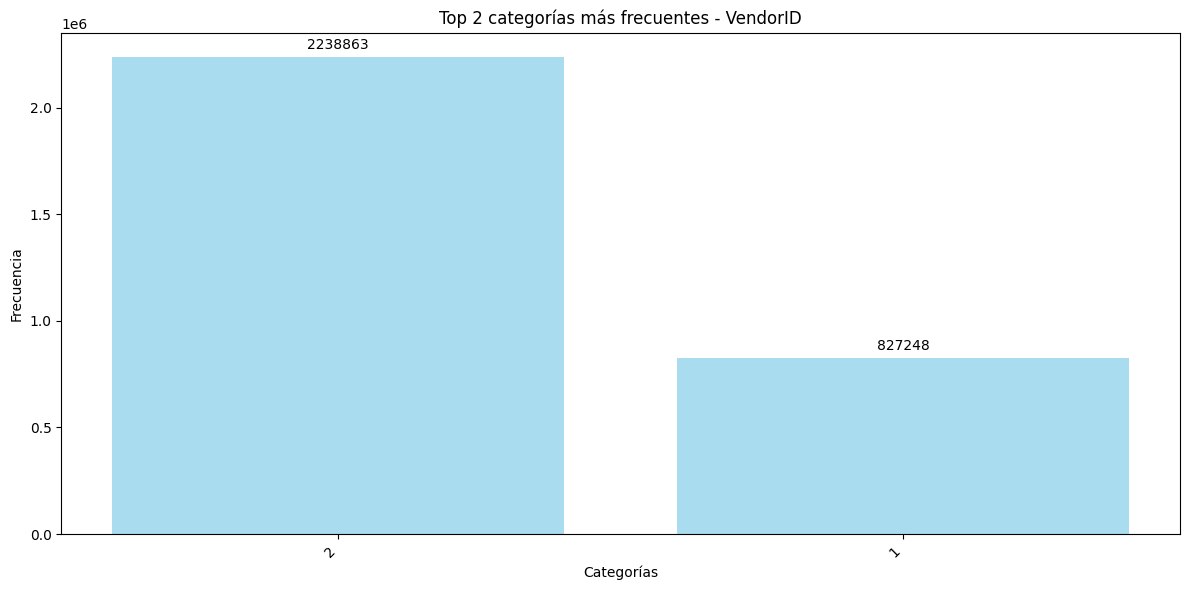

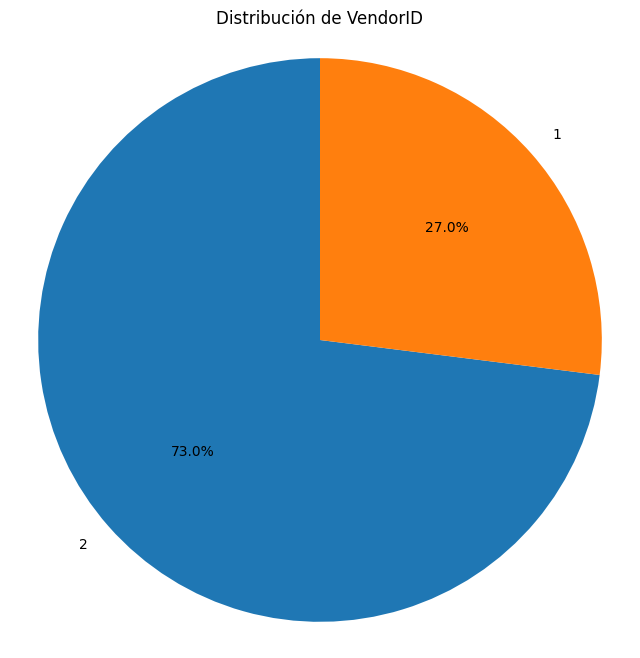

No hay datos para mostrar en el gráfico de evolución temporal.
No hay datos para mostrar en el gráfico de barras apiladas.
=============== Frecuencia de valores ===============
2: 2238863
1: 827248
RESUMEN ESTADÍSTICO - VendorID
Total de registros: 3,066,111
Categorías únicas: 2
Categoría más frecuente: '2'  (2,238,863 veces,  73.0%)
Categoría menos frecuente: '1'  (827,248 veces,  27.0%)
Concentración 2 valores más repetidos:  100.0% de los datos
Período analizado: 2023-01-01 00:00:00  a 2023-01-31 23:58:56
Períodos de semana: 6


<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

In [46]:
col_name = 'VendorID'

info = analyze_categorical_variable_spark(ds_filtered_dates, col_name, col_fecha)

**3.2) tpep_pickup_datetime**

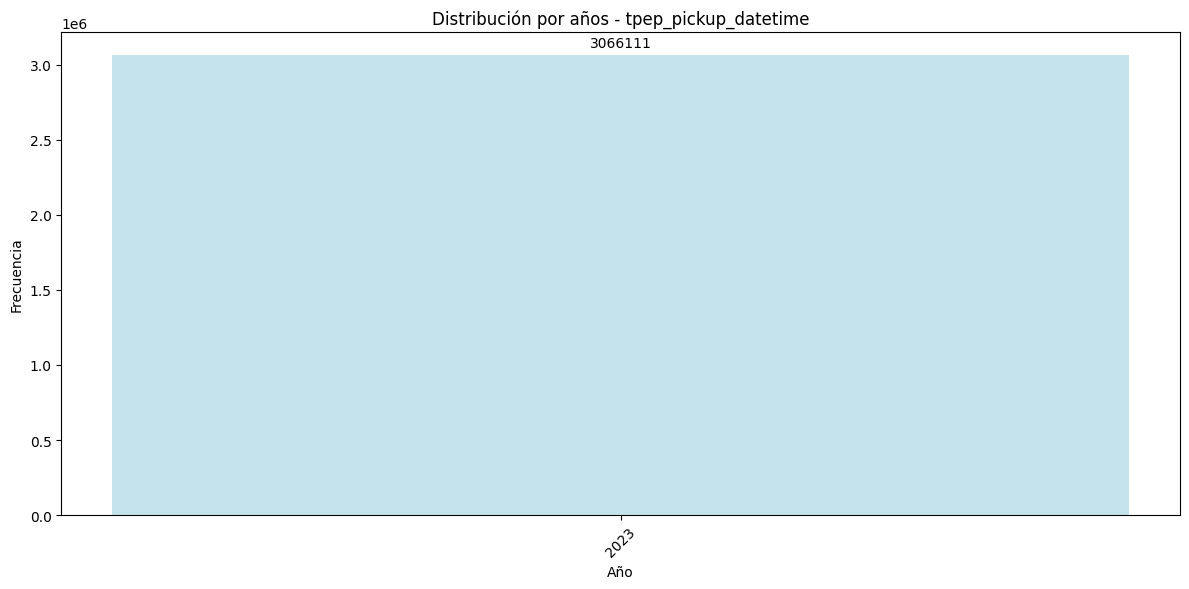

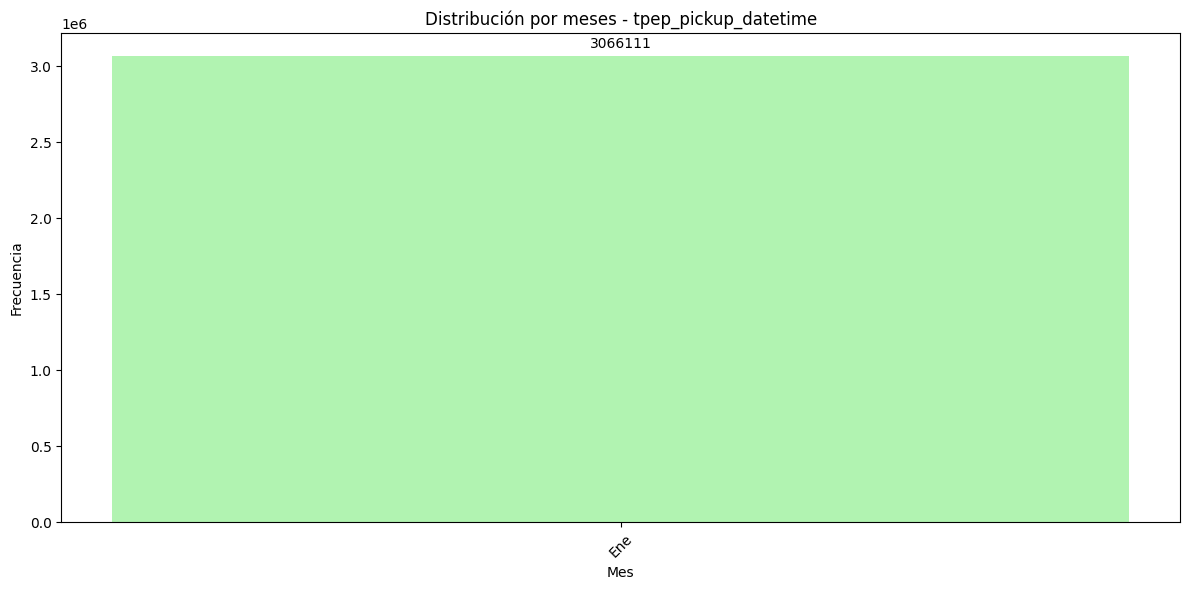

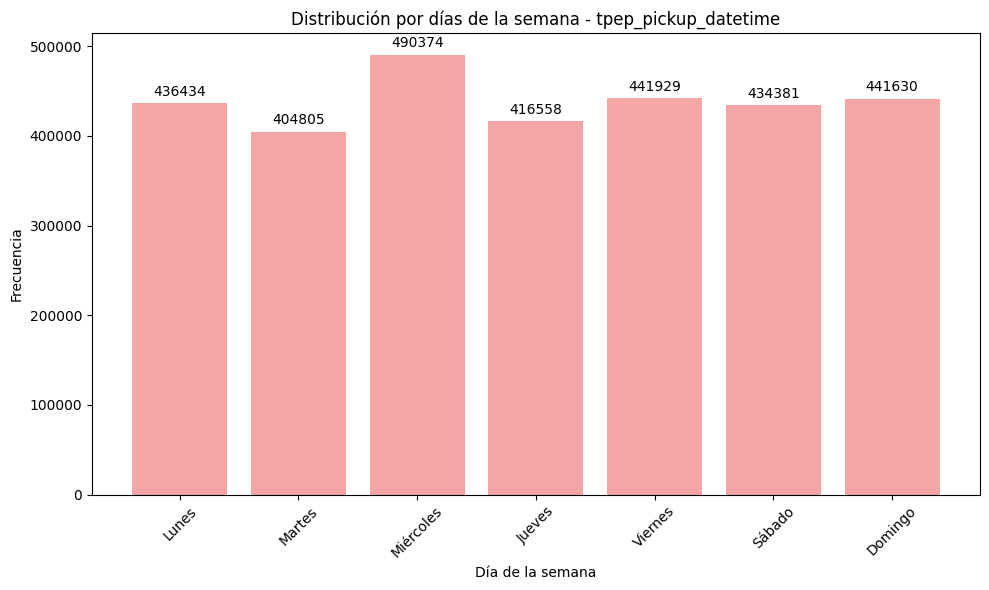

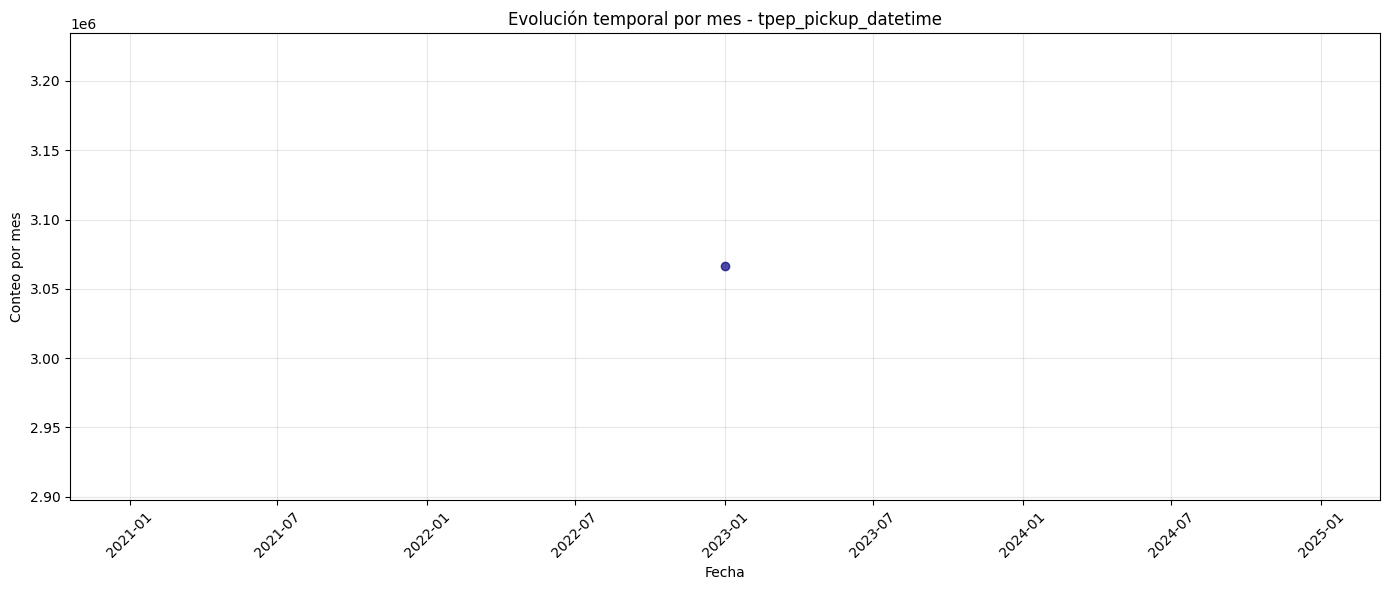

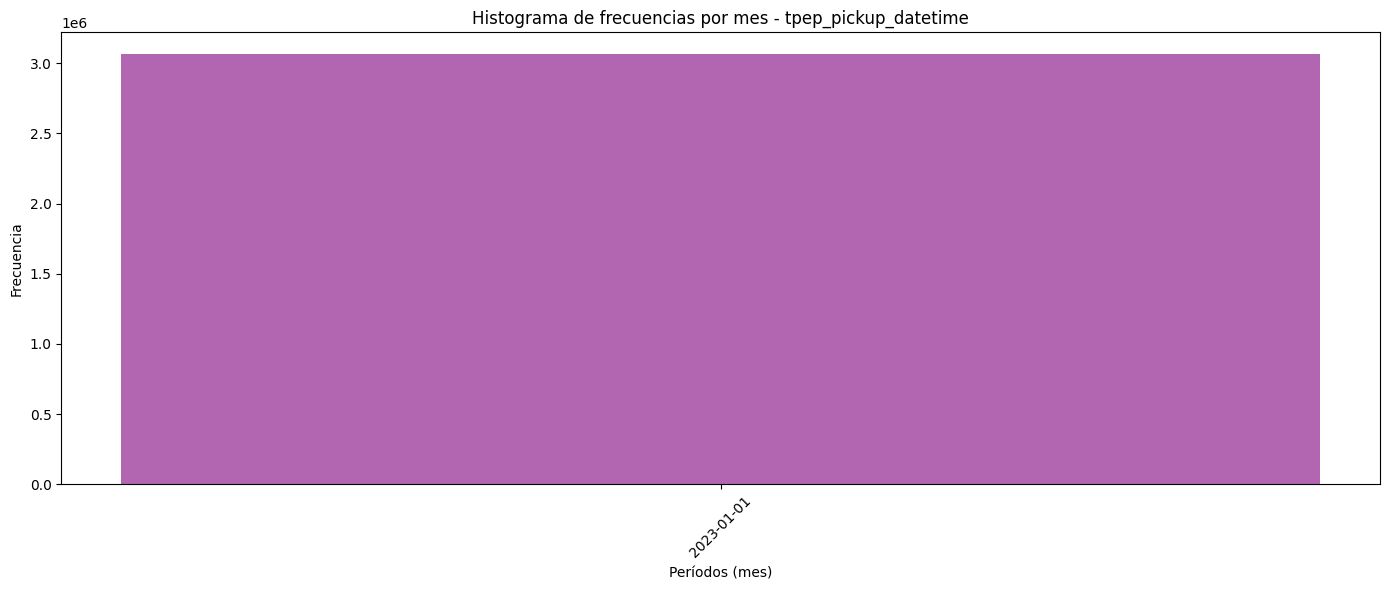

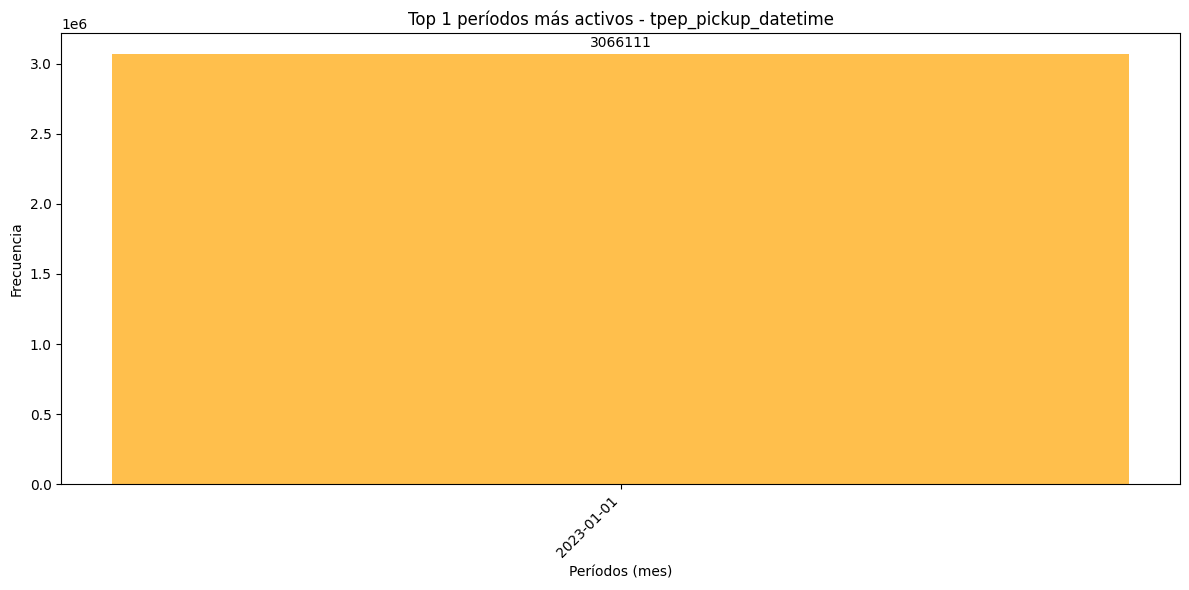

RESUMEN ESTADÍSTICO - tpep_pickup_datetime
Total de registros: 3,066,111
Fecha mínima: 2023-01-01
Fecha máxima: 2023-01-31
Rango temporal: 30 días (0 años)
Años únicos: 1
Meses únicos: 1

PATRONES TEMPORALES:
Año más frecuente: 2023
Mes más frecuente: Ene
Día de semana más frecuente:  Miércoles

ANÁLISIS POR MES:
Períodos con datos: 1
Promedio por mes: 3066111.0
Mediana por mes: 3066111.0
Máximo por mes: 3,066,111
Mínimo por mes: 3,066,111
Concentración top 1:  100.0% de los datos



In [47]:
col_name = 'tpep_pickup_datetime'

info = analyze_datetime_variable_spark(ds_filtered_dates, col_name)

Se muestran valores fuera de Enero de 2023 de manera residual, y la graficación de esta variable de fecha apenas aporta información, salvo comprobar que los viajes están distribuidos de manera bastante uniforme entre los días de la semana.

**3.3) tpep_dropoff_datetime**

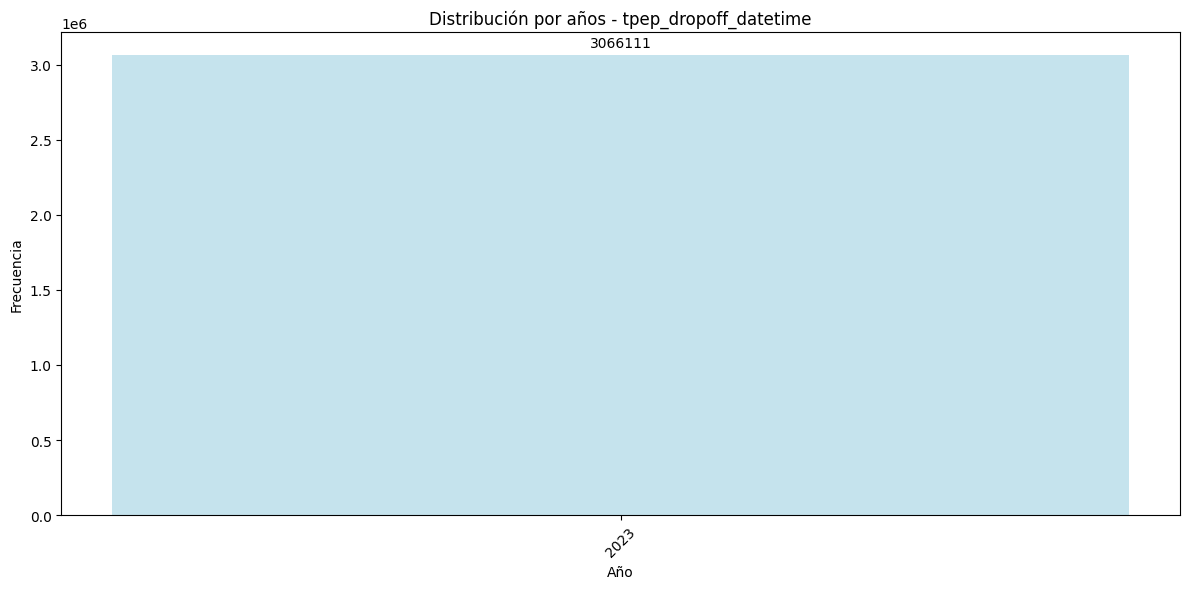

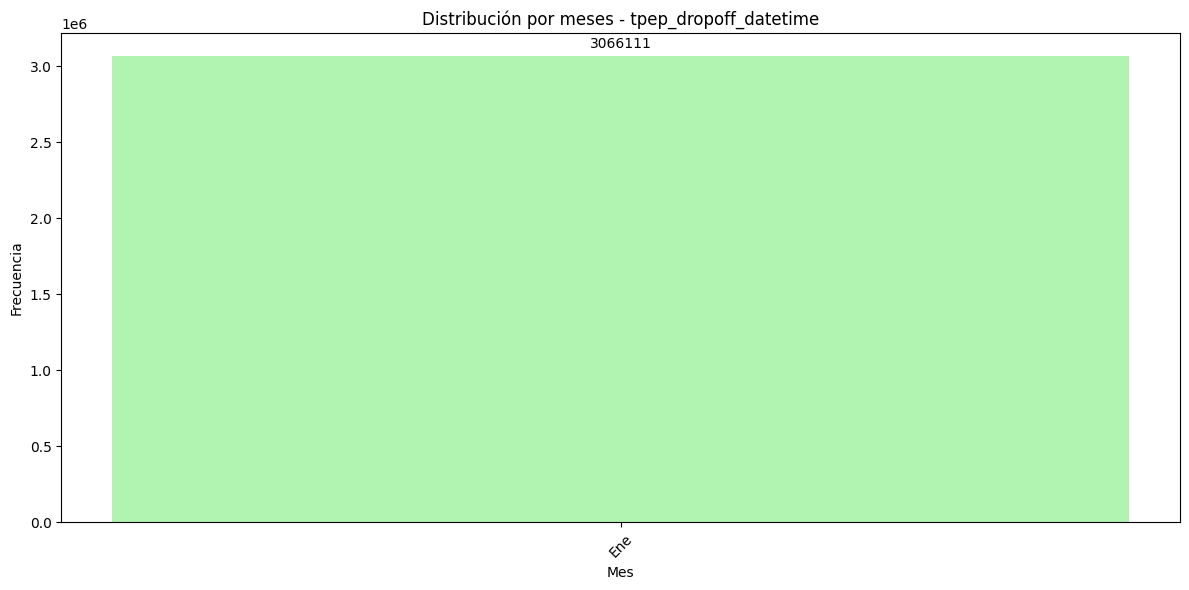

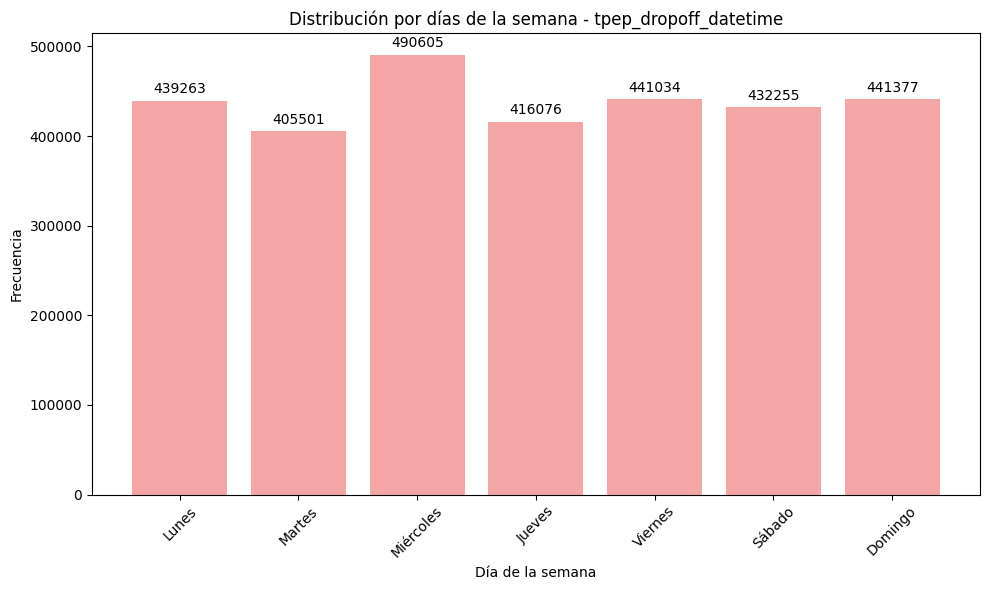

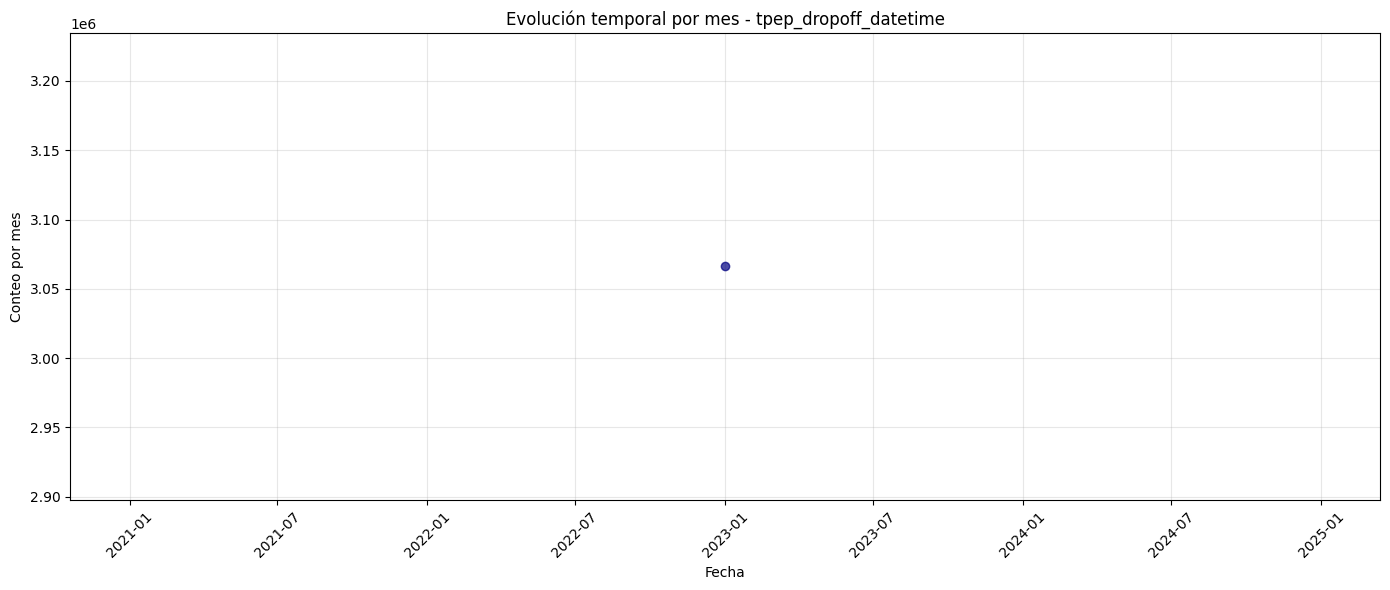

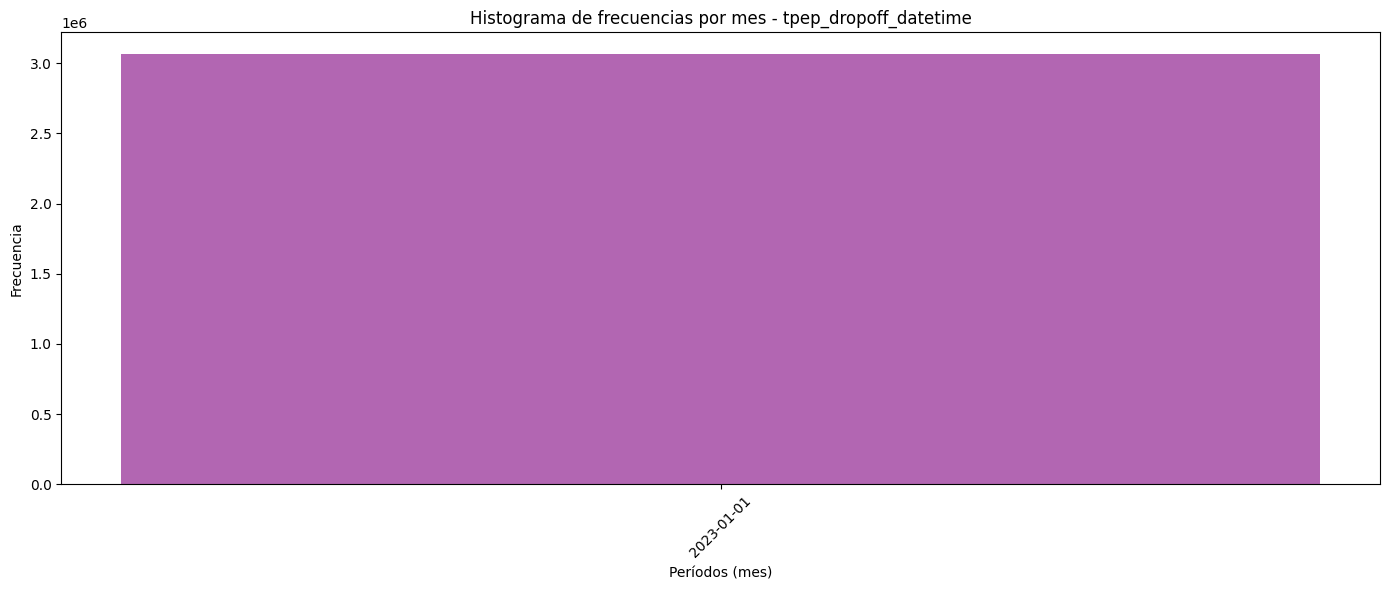

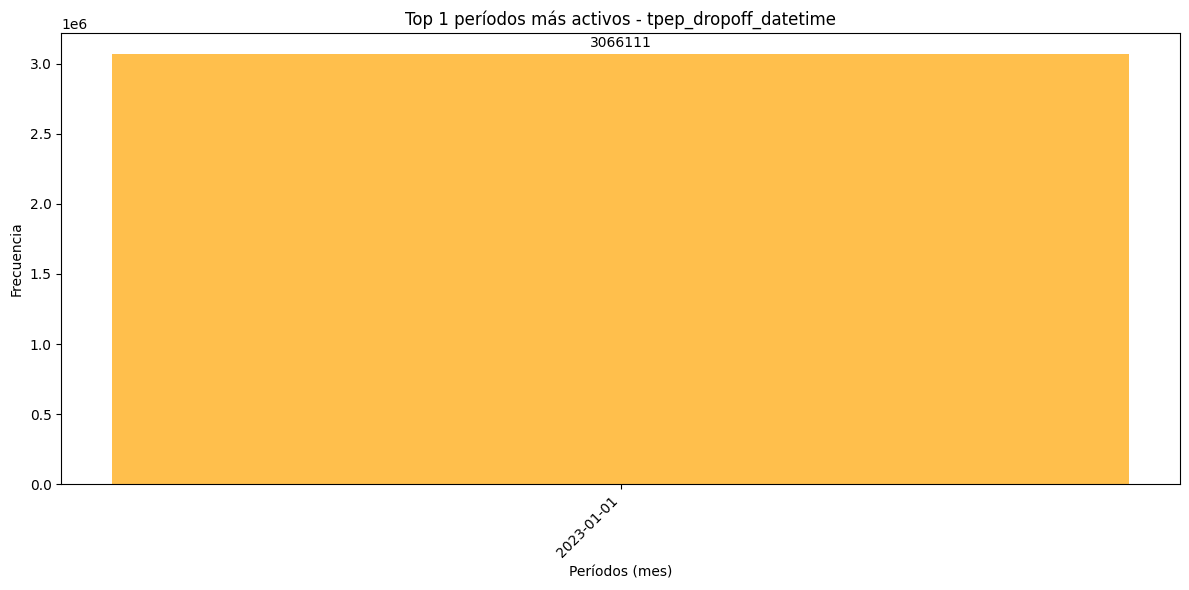

RESUMEN ESTADÍSTICO - tpep_dropoff_datetime
Total de registros: 3,066,111
Fecha mínima: 2023-01-01
Fecha máxima: 2023-01-31
Rango temporal: 30 días (0 años)
Años únicos: 1
Meses únicos: 1

PATRONES TEMPORALES:
Año más frecuente: 2023
Mes más frecuente: Ene
Día de semana más frecuente:  Miércoles

ANÁLISIS POR MES:
Períodos con datos: 1
Promedio por mes: 3066111.0
Mediana por mes: 3066111.0
Máximo por mes: 3,066,111
Mínimo por mes: 3,066,111
Concentración top 1:  100.0% de los datos



In [48]:
col_name = 'tpep_dropoff_datetime'

info = analyze_datetime_variable_spark(ds_filtered_dates, col_name)

Se muestran valores fuera de Enero de 2023 de manera residual, y la información que aporta la graficación de la variable se limita a mostrar una distribución bastante uniforme entre los días de la semana.

**3.4) passenger_count**

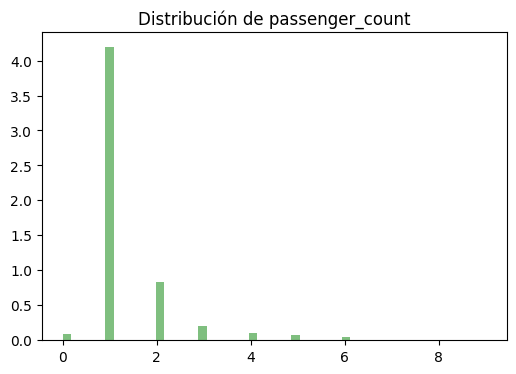

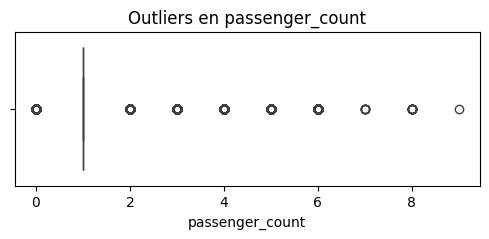

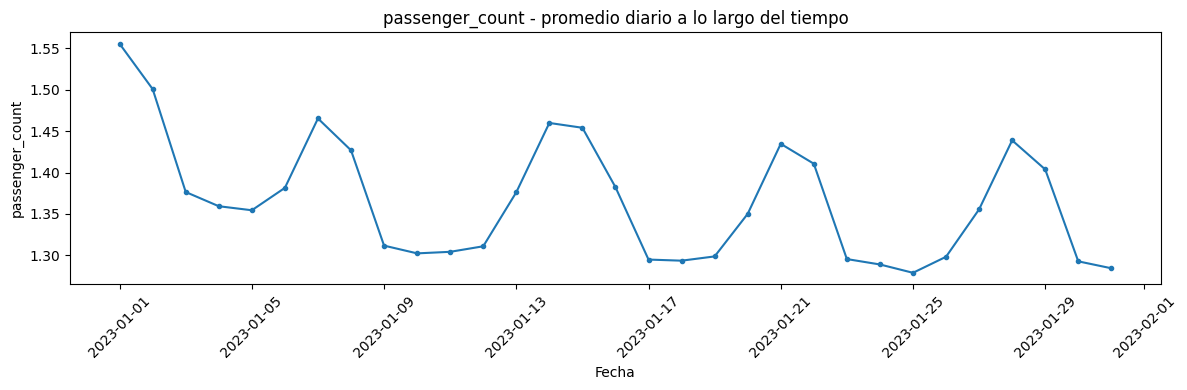

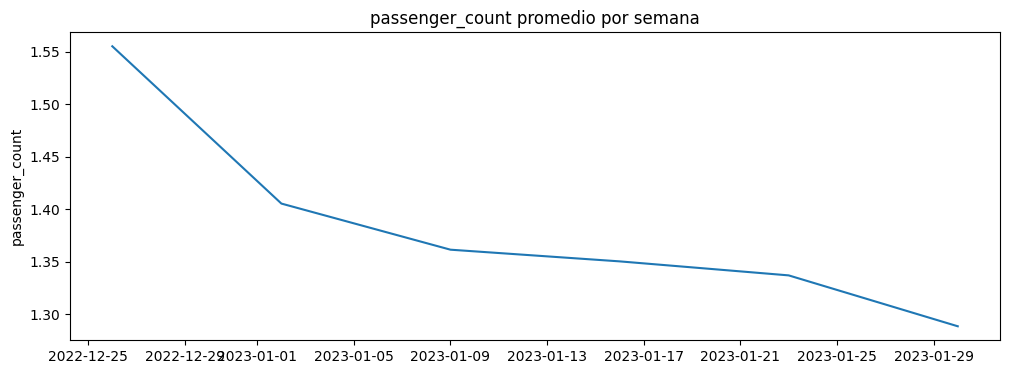

{'skewness': np.float64(2.8753925198342123),
 'sesgo': 'muy sesgada',
 'num_outliers': 733467,
 'porcentaje_outliers': 24.494770540298465}

In [49]:
col_name = 'passenger_count'

info = analyze_numeric_variable_spark(ds_filtered_dates, col_name, col_fecha)

Distribución muy sesgada, con casi un 25% de outliers y una clara relación temporal.

**3.5) trip_distance**

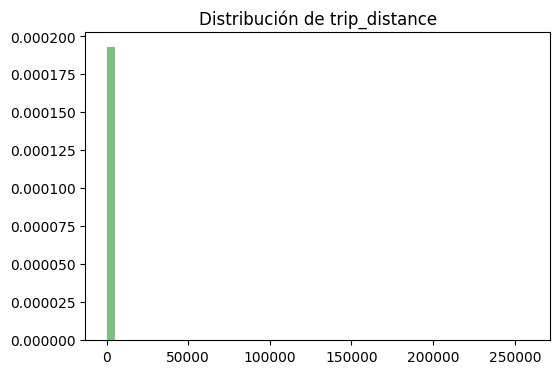

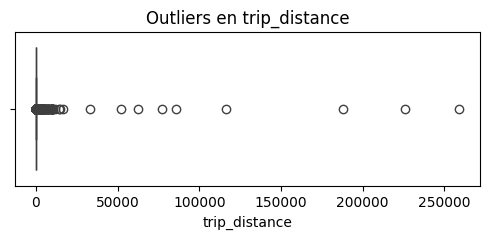

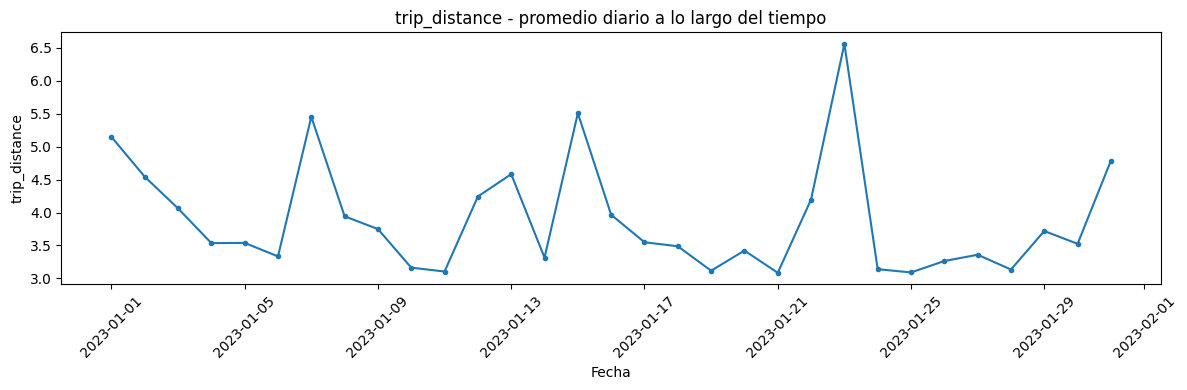

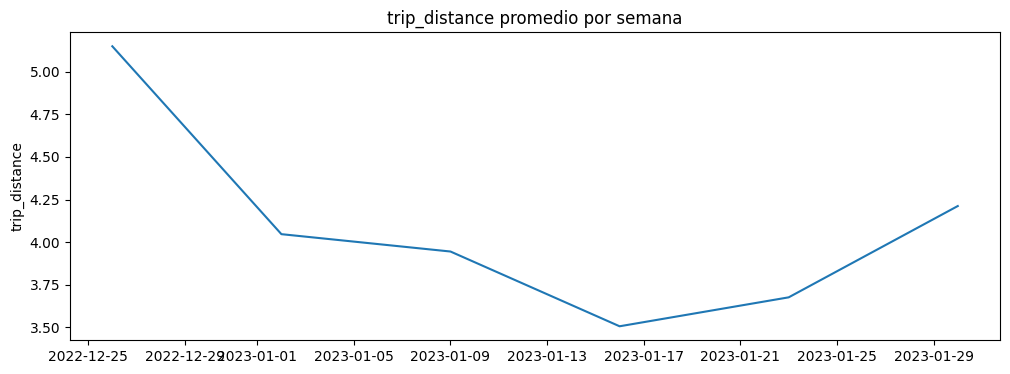

{'skewness': np.float64(810.3209589972467),
 'sesgo': 'muy sesgada',
 'num_outliers': 389990,
 'porcentaje_outliers': 12.719369911917736}

In [50]:
col_name = 'trip_distance'

info = analyze_numeric_variable_spark(ds_filtered_dates, col_name, col_fecha)

Distribución muy sesgada, con más del 10% de outliers y sin relación temporal.

**3.6) RatecodeID**

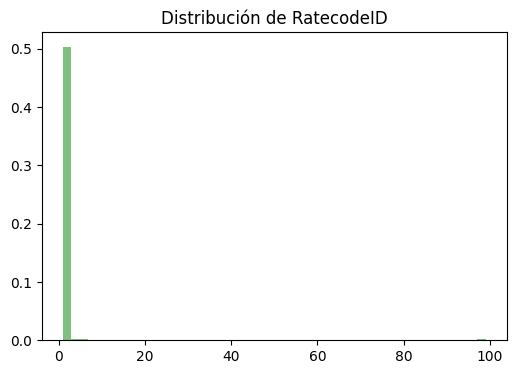

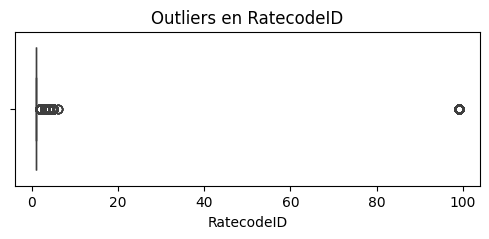

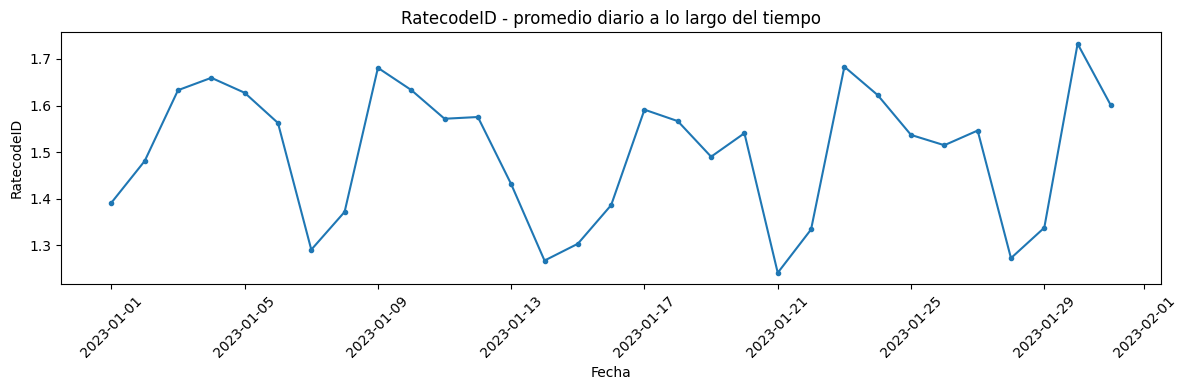

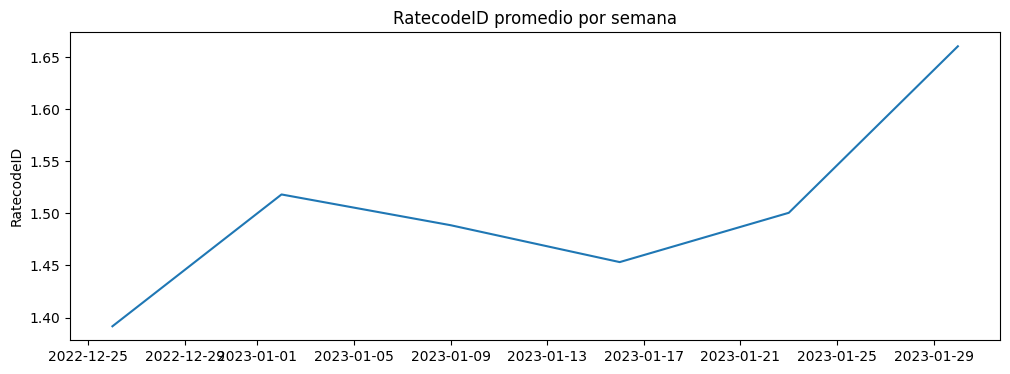

{'skewness': np.float64(14.943936222504833),
 'sesgo': 'muy sesgada',
 'num_outliers': 155602,
 'porcentaje_outliers': 5.196464579335569}

In [51]:
col_name = 'RatecodeID'

info = analyze_numeric_variable_spark(ds_filtered_dates, col_name, col_fecha)

Distribución muy sesgada y sobre un 5% de outliers.

Esta variable presenta una relación temporal moderada, muestra picos y valles en ciclos regulares aunque poco pronunciados.

**3.7) store_and_fwd_flag**

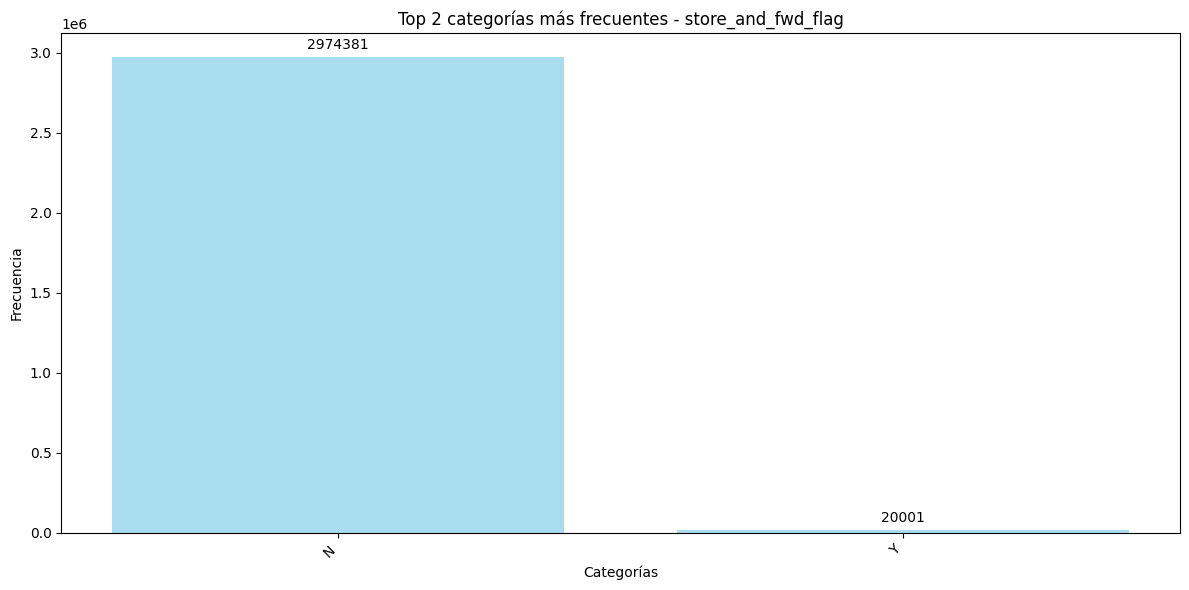

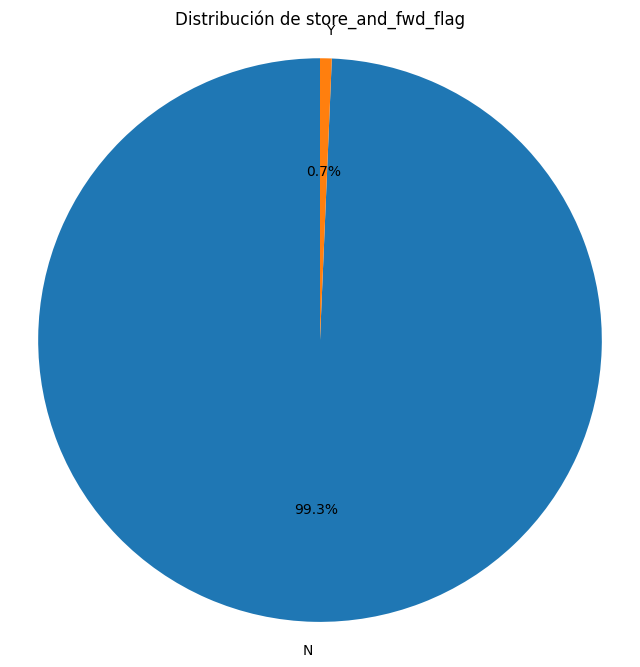

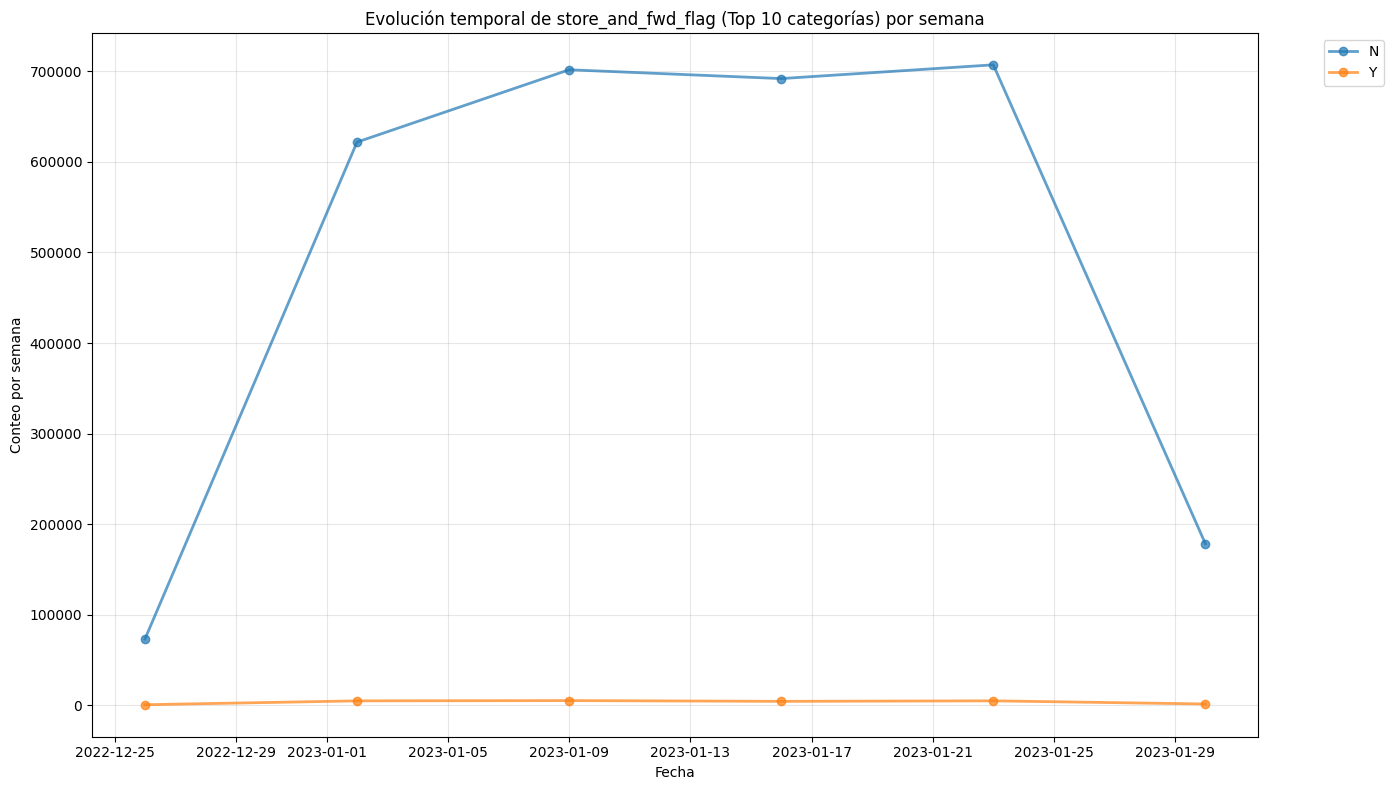

<Figure size 1400x800 with 0 Axes>

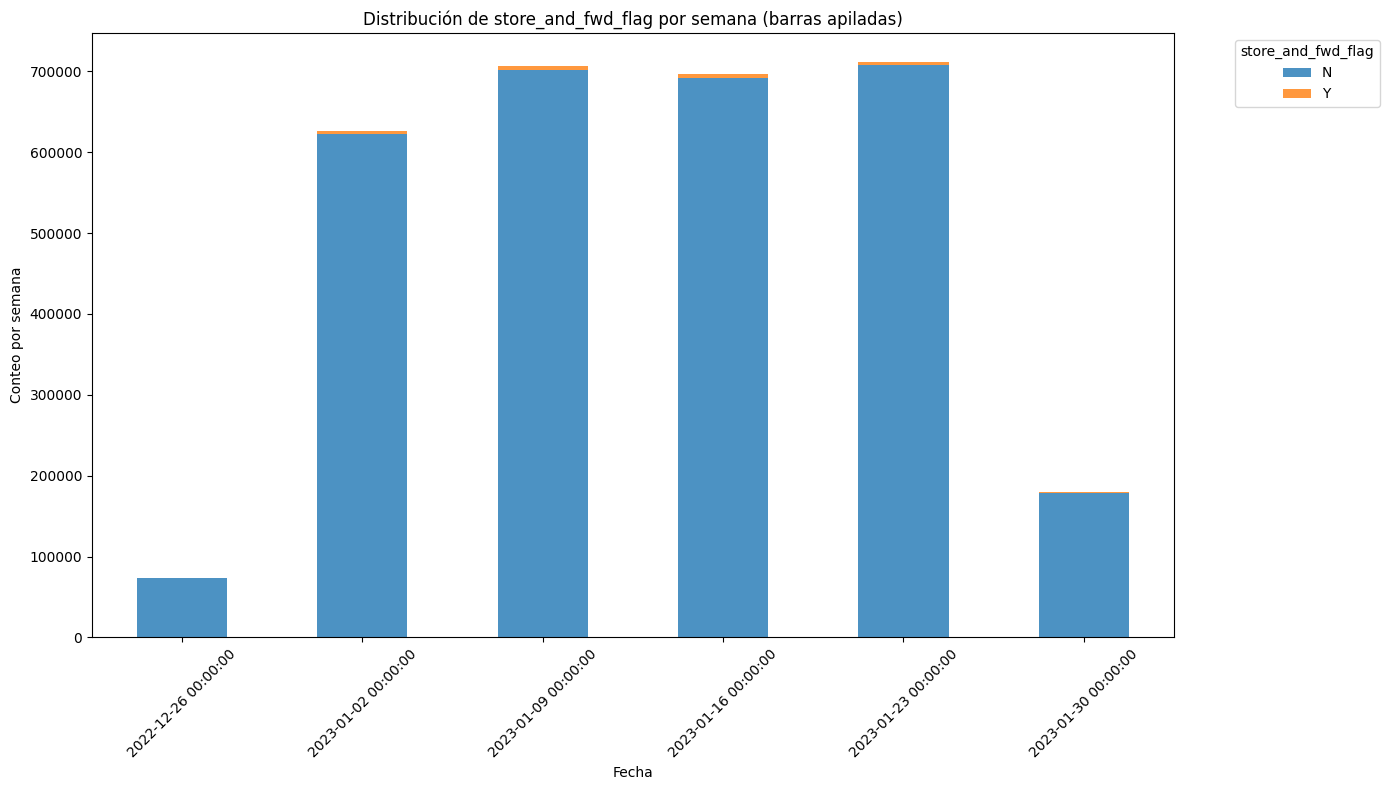

=============== Frecuencia de valores ===============
N: 2974381
Y: 20001
RESUMEN ESTADÍSTICO - store_and_fwd_flag
Total de registros: 2,994,382
Categorías únicas: 2
Categoría más frecuente: 'N'  (2,974,381 veces,  99.3%)
Categoría menos frecuente: 'Y'  (20,001 veces,  0.7%)
Concentración 2 valores más repetidos:  100.0% de los datos
Período analizado: 2023-01-01 00:00:05  a 2023-01-31 23:58:56
Períodos de semana: 6


In [52]:
col_name = 'store_and_fwd_flag'

info = analyze_categorical_variable_spark(ds_filtered_dates, col_name, col_fecha)

**3.8) PULocationID**

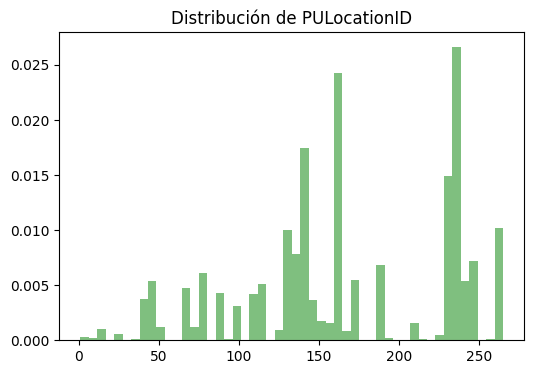

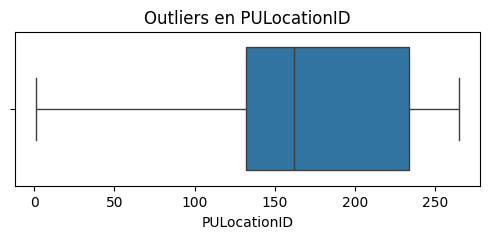

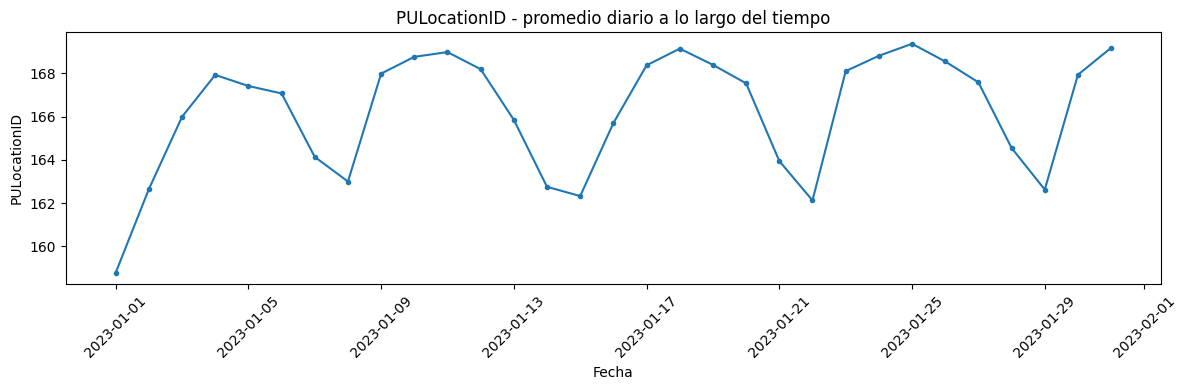

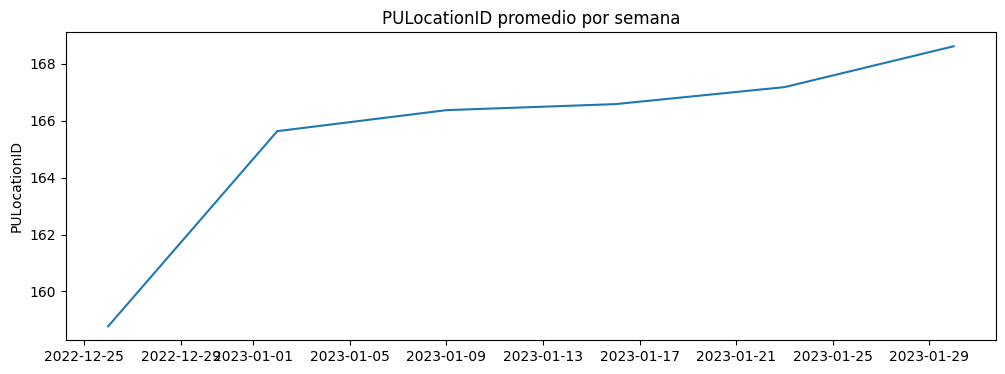

{'skewness': np.float64(-0.25606846295786106),
 'sesgo': 'ligeramente sesgada',
 'num_outliers': 0,
 'porcentaje_outliers': 0.0}

In [53]:
col_name = 'PULocationID'

info = analyze_numeric_variable_spark(ds_filtered_dates, col_name, col_fecha)

Distribución ligeramente sesgada, sin outliers y con relación temporal.

**3.9) DOLocationID**

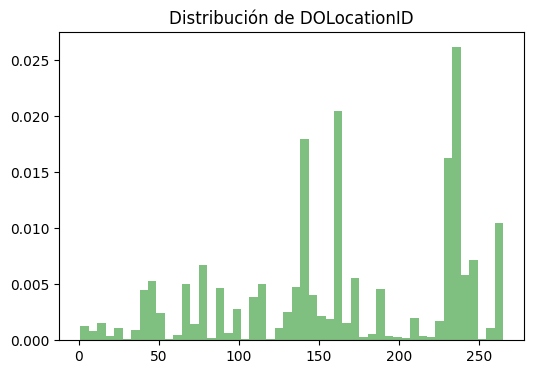

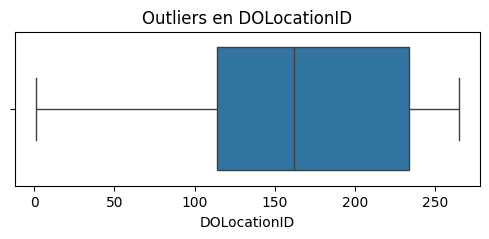

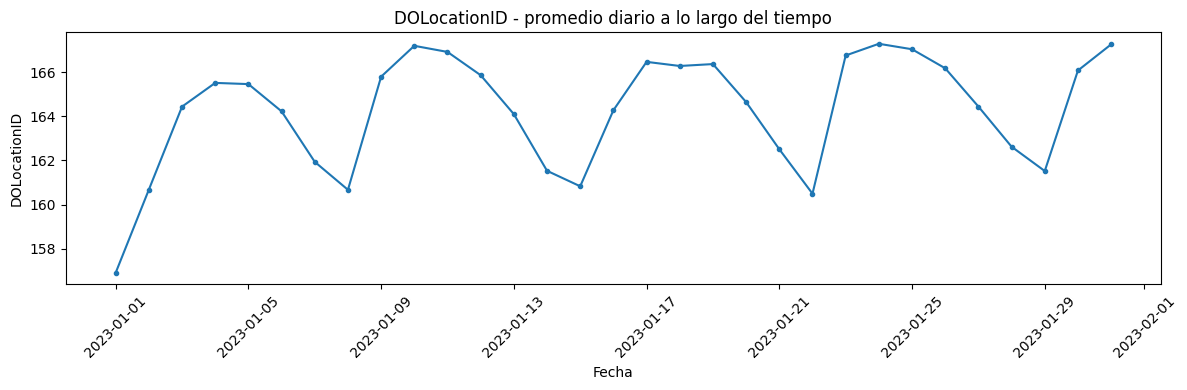

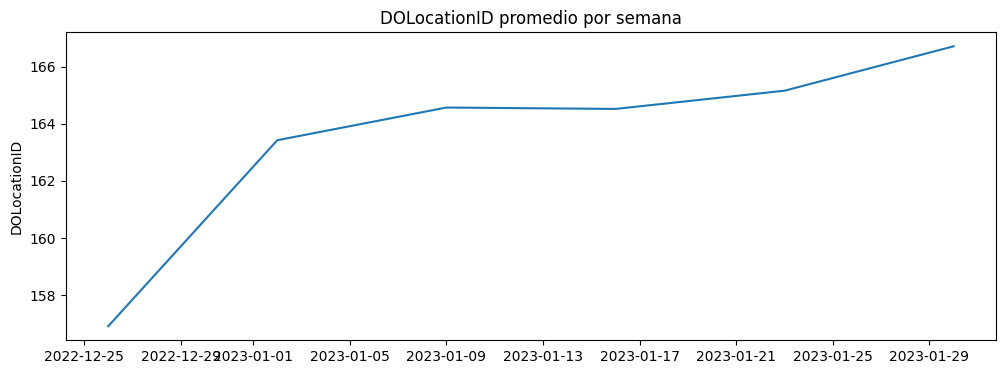

{'skewness': np.float64(-0.36635327670928636),
 'sesgo': 'ligeramente sesgada',
 'num_outliers': 0,
 'porcentaje_outliers': 0.0}

In [54]:
col_name = 'DOLocationID'

info = analyze_numeric_variable_spark(ds_filtered_dates, col_name, col_fecha)

Distribución ligeramente sesgada, sin outliers y con relación temporal.

**3.10) payment_type**

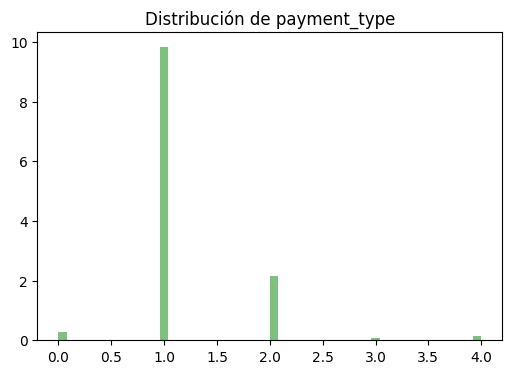

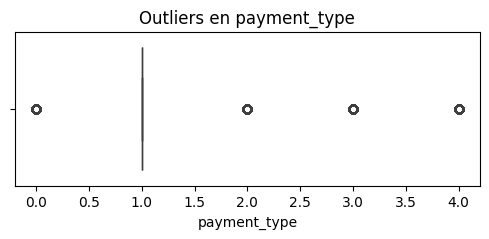

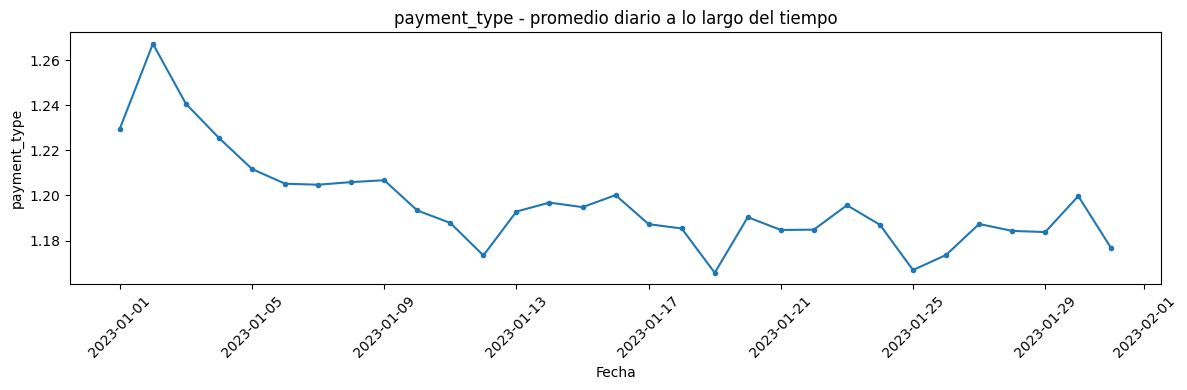

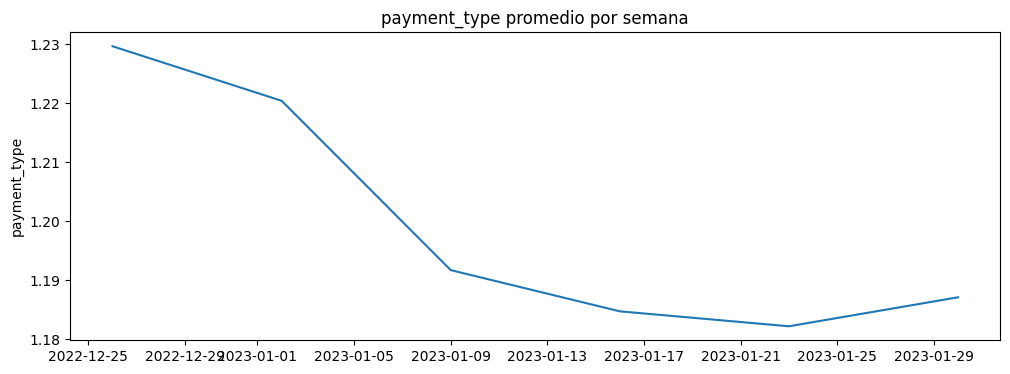

{'skewness': np.float64(2.15175281035143),
 'sesgo': 'muy sesgada',
 'num_outliers': 655142,
 'porcentaje_outliers': 21.36719773028439}

In [55]:
col_name = 'payment_type'

info = analyze_numeric_variable_spark(ds_filtered_dates, col_name, col_fecha)

Distribución muy sesgada, con más del 20% de outliers y una relación temporal muy débil.

**3.11) fare_amount**

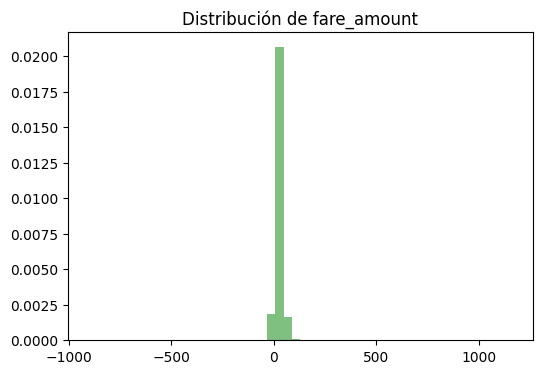

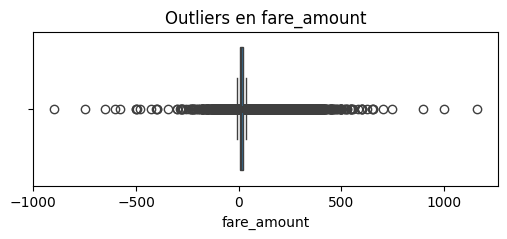

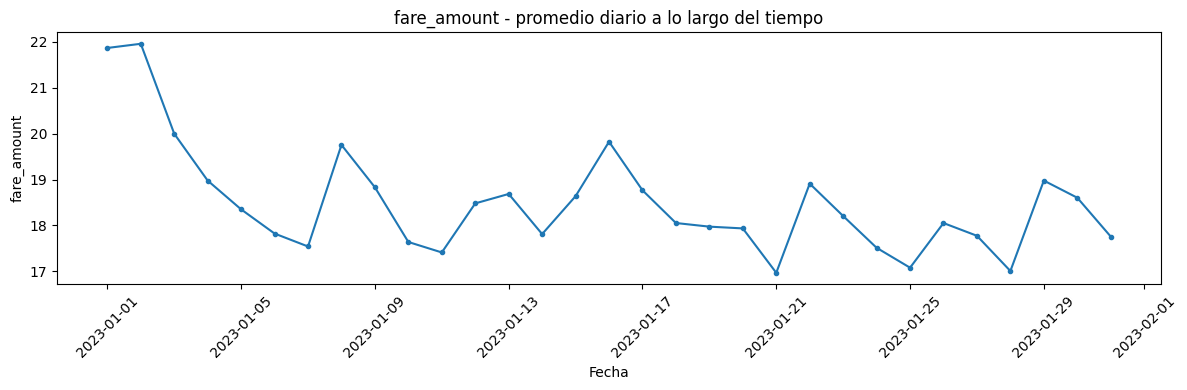

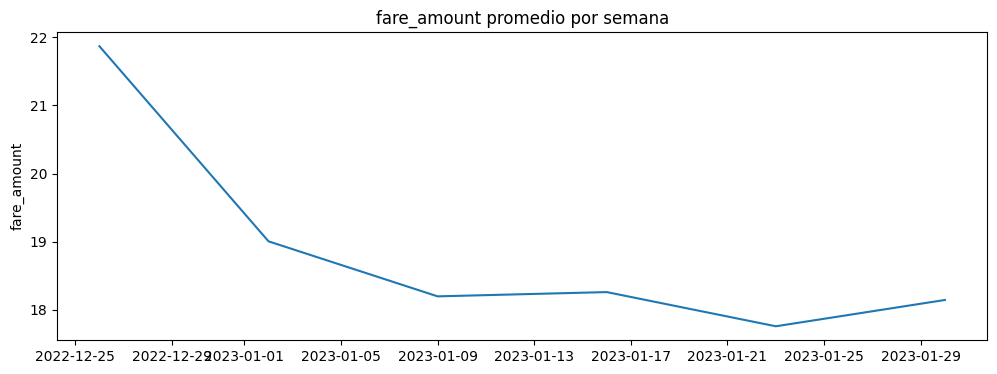

{'skewness': np.float64(3.2149454926602696),
 'sesgo': 'muy sesgada',
 'num_outliers': 325009,
 'porcentaje_outliers': 10.600040246422912}

In [56]:
col_name = 'fare_amount'

info = analyze_numeric_variable_spark(ds_filtered_dates, col_name, col_fecha)

Distribución muy sesgada, sobre un 10% de outliers y relación temporal moderada.

**3.12) extra**

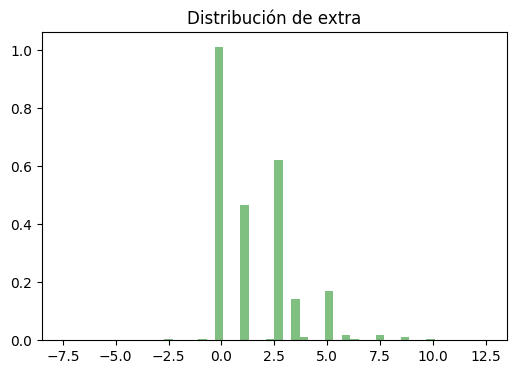

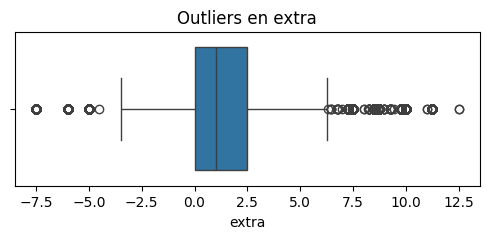

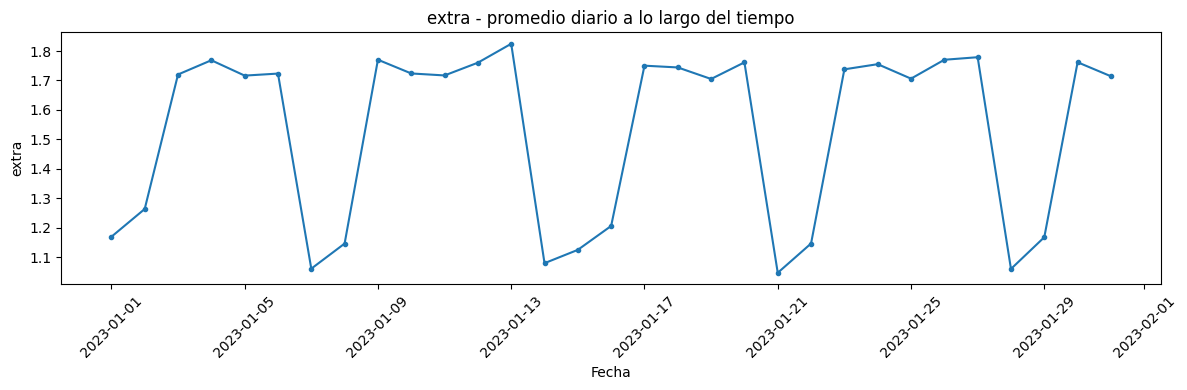

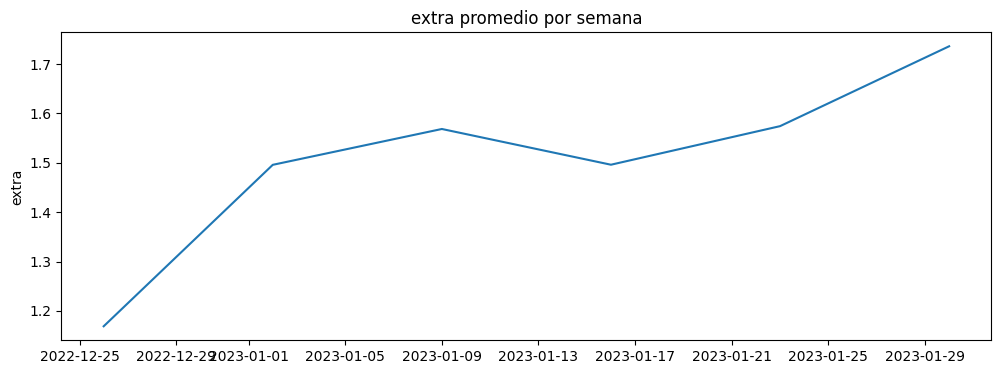

{'skewness': np.float64(1.2685698447251135),
 'sesgo': 'muy sesgada',
 'num_outliers': 44700,
 'porcentaje_outliers': 1.4578728558750809}

In [57]:
col_name = 'extra'

info = analyze_numeric_variable_spark(ds_filtered_dates, col_name, col_fecha)

Distribución muy sesgada, con menos del 2% de outliers y con relación temporal.

**3.13) mta_tax**

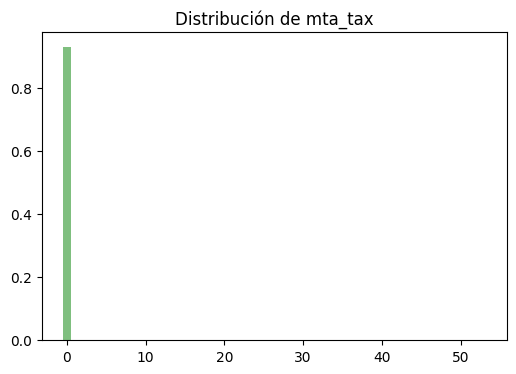

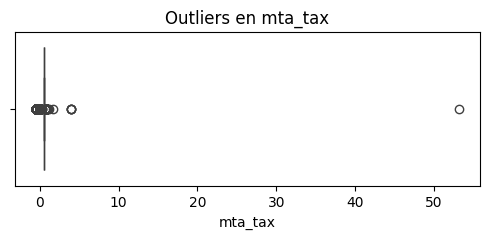

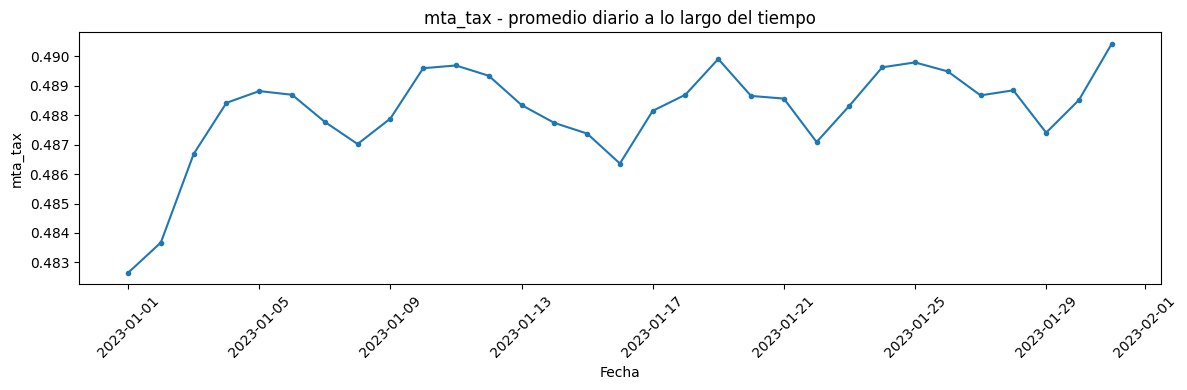

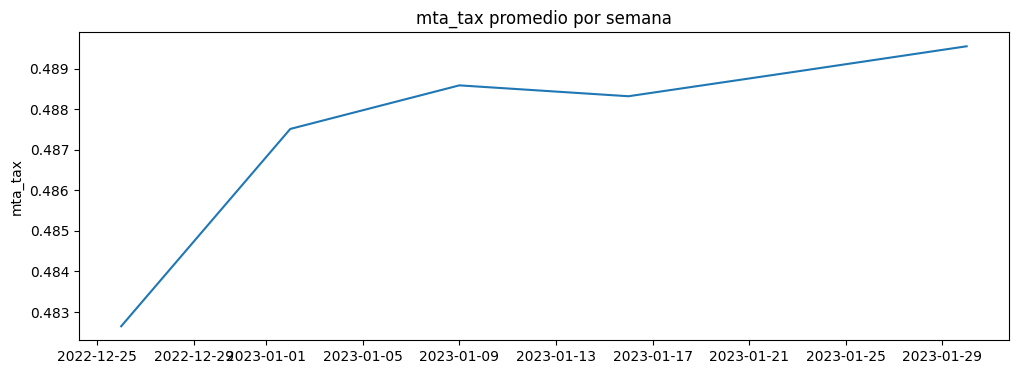

{'skewness': np.float64(35.330204789153655),
 'sesgo': 'muy sesgada',
 'num_outliers': 48684,
 'porcentaje_outliers': 1.587809443298041}

In [58]:
col_name = 'mta_tax'

info = analyze_numeric_variable_spark(ds_filtered_dates, col_name, col_fecha)

Distribución muy sesgada, con sólo un 1% de outliers y una relación temporal muy débil.

**3.14) tip_amount**

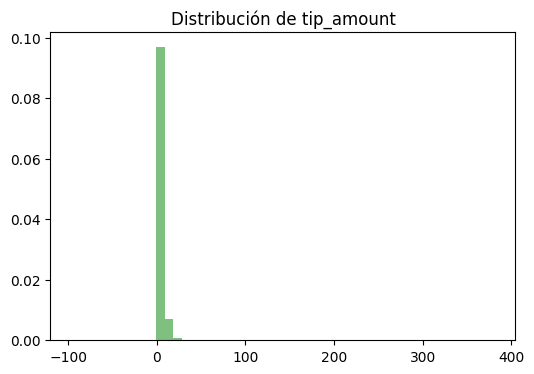

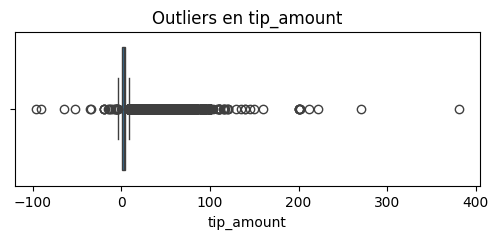

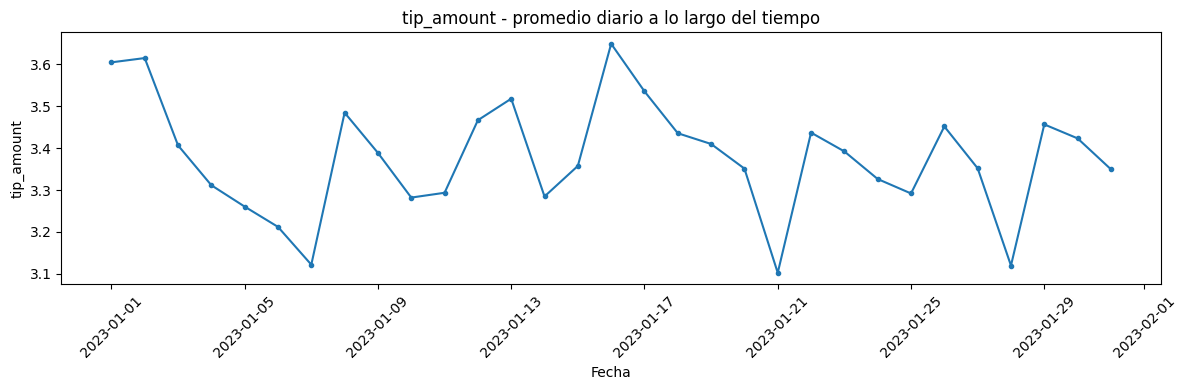

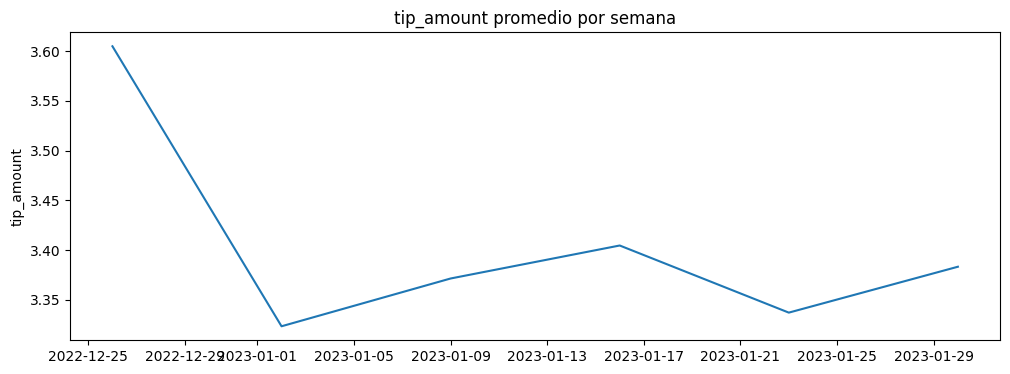

{'skewness': np.float64(4.225108318432689),
 'sesgo': 'muy sesgada',
 'num_outliers': 221117,
 'porcentaje_outliers': 7.211643675000677}

In [59]:
col_name = 'tip_amount'

info = analyze_numeric_variable_spark(ds_filtered_dates, col_name, col_fecha)

Distribución muy sesgada, con menos de un 10% de outliers y una relación temporal moderada.

**3.15) tolls_amount**

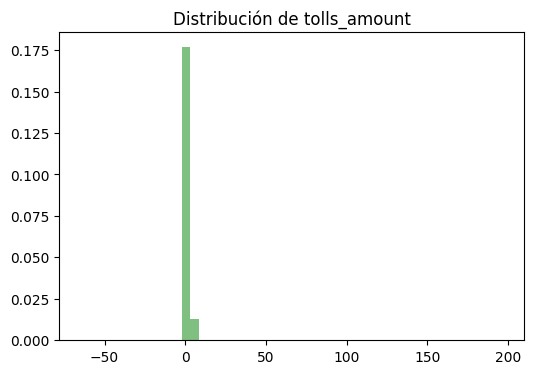

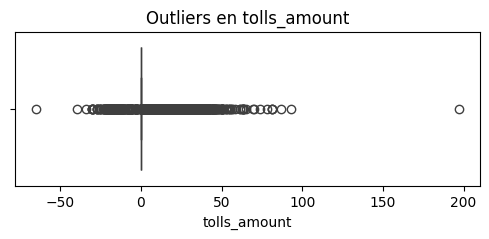

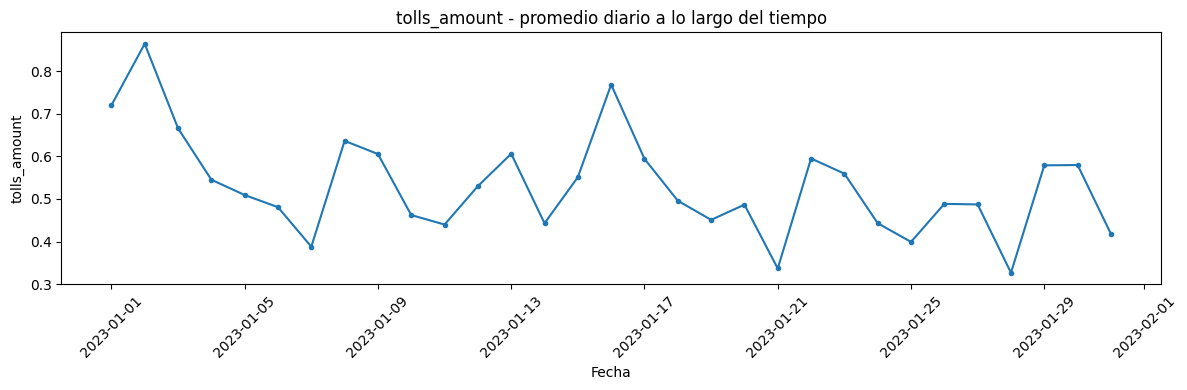

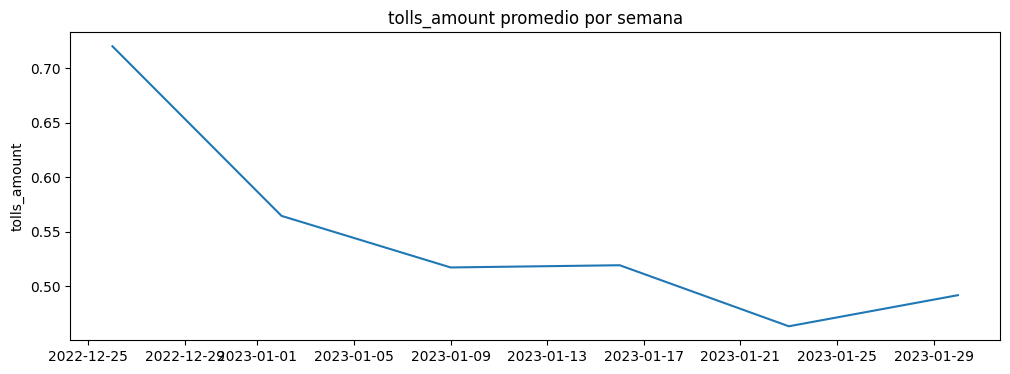

{'skewness': np.float64(5.3903487475812675),
 'sesgo': 'muy sesgada',
 'num_outliers': 226356,
 'porcentaje_outliers': 7.38251159204608}

In [60]:
col_name = 'tolls_amount'

info = analyze_numeric_variable_spark(ds_filtered_dates, col_name, col_fecha)

Distribución muy sesgada, menos del 10% de outliers y relación temporal moderada.

**3.16) improvement_surcharge**

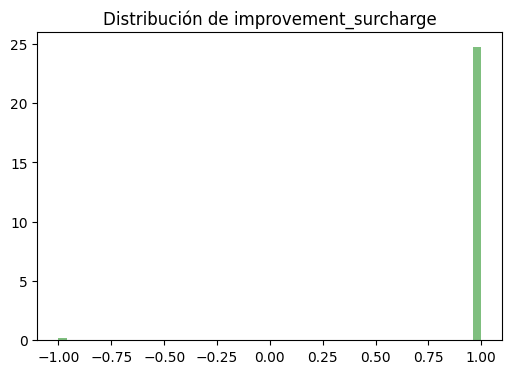

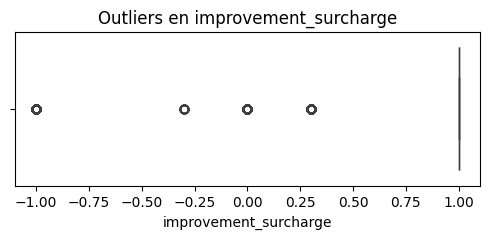

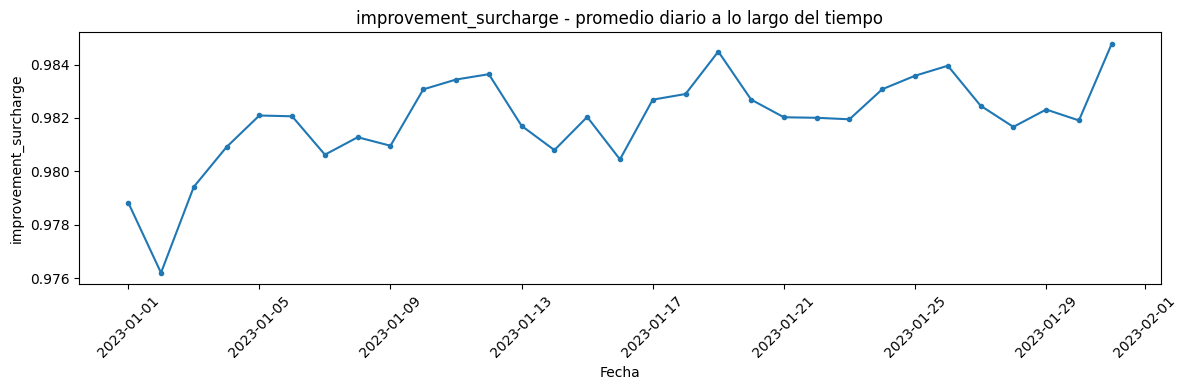

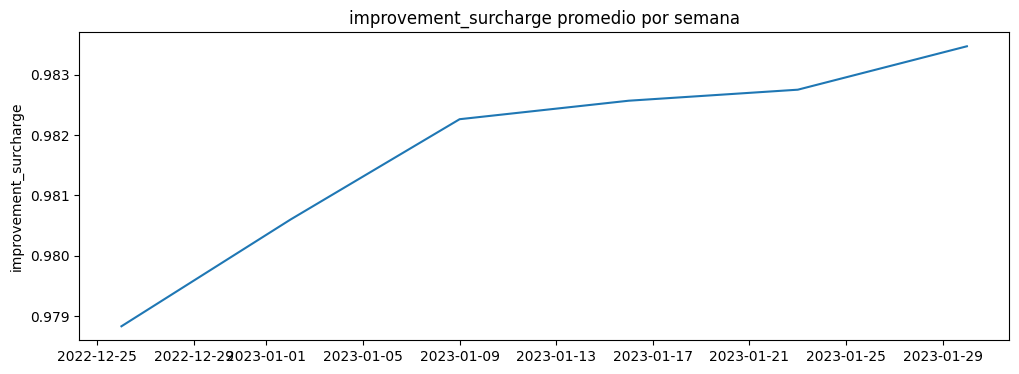

{'skewness': np.float64(-10.48786874800917),
 'sesgo': 'muy sesgada',
 'num_outliers': 31374,
 'porcentaje_outliers': 1.0232506259558116}

In [61]:
col_name = 'improvement_surcharge'

info = analyze_numeric_variable_spark(ds_filtered_dates, col_name, col_fecha)

Distribución muy sesgada, sobre un 1% de outliers y sin relación temporal.

**3.17) total_amount**

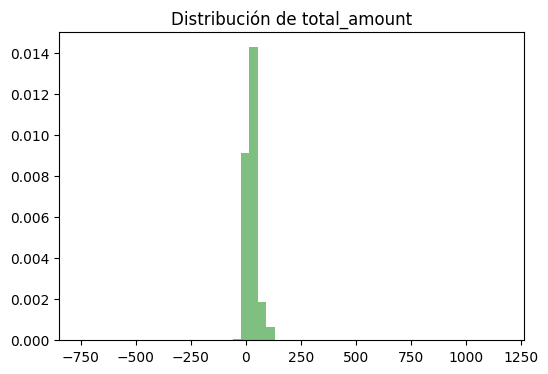

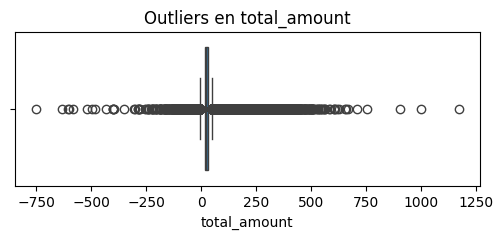

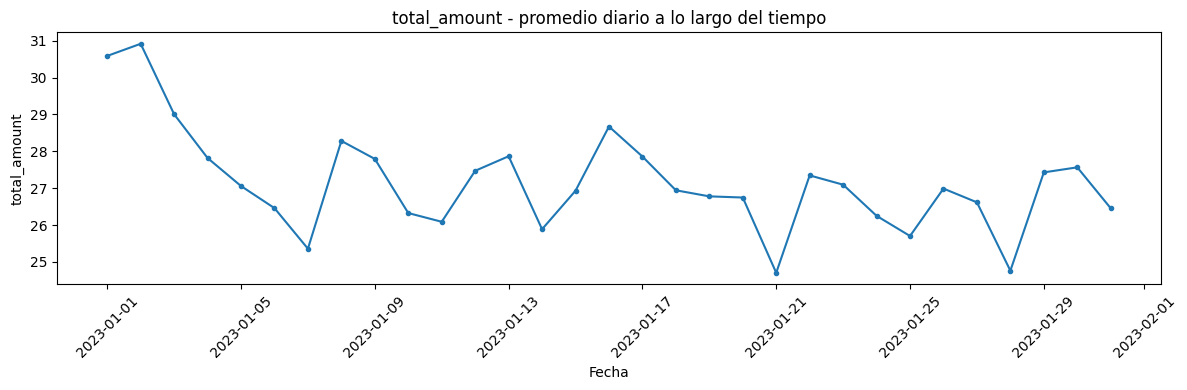

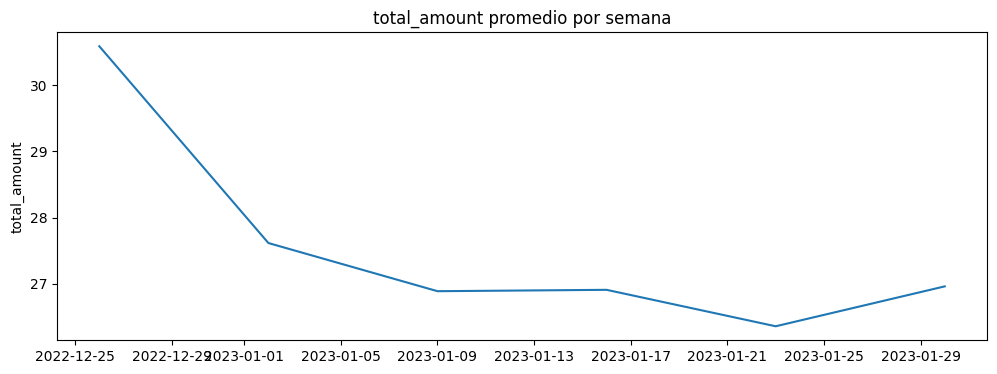

{'skewness': np.float64(2.830096516373662),
 'sesgo': 'muy sesgada',
 'num_outliers': 371384,
 'porcentaje_outliers': 12.112542566136712}

In [62]:
col_name = 'total_amount'

info = analyze_numeric_variable_spark(ds_filtered_dates, col_name, col_fecha)

Distribución muy sesgada, algo más del 10% de outliers y relación temporal moderada.

**3.18) congestion_surcharge**

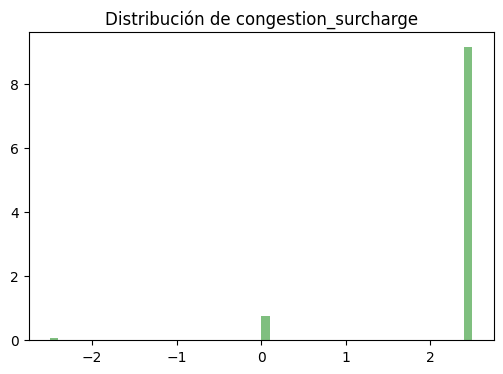

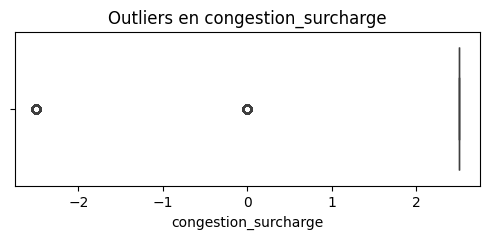

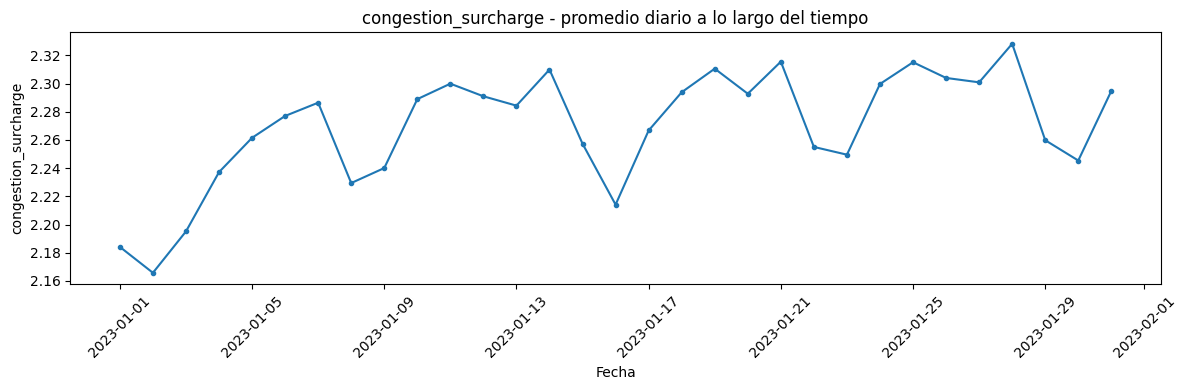

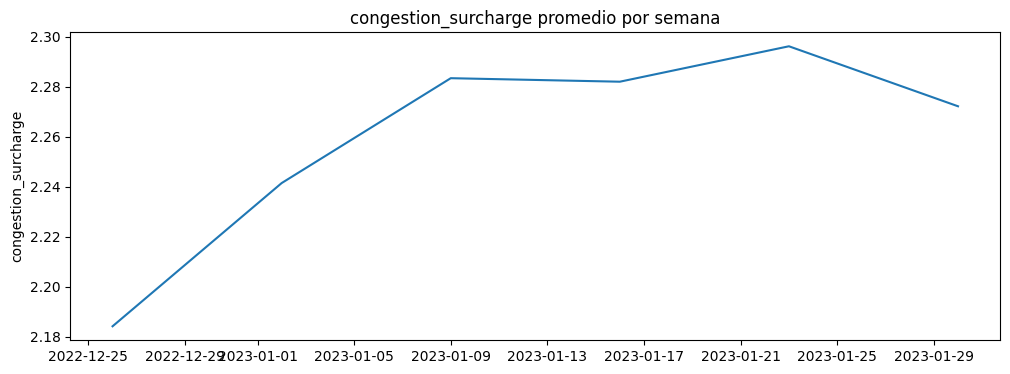

{'skewness': np.float64(-3.5090318747158267),
 'sesgo': 'muy sesgada',
 'num_outliers': 250637,
 'porcentaje_outliers': 8.370241338613443}

In [63]:
col_name = 'congestion_surcharge'

info = analyze_numeric_variable_spark(ds_filtered_dates, col_name, col_fecha)

Distribución muy sesgada, menos del 10% de outliers y relación temporal moderada.

**3.19) airport_fee**

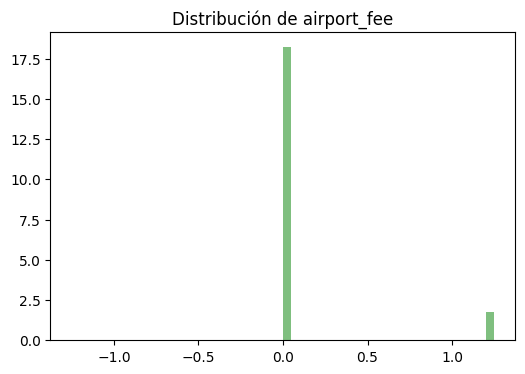

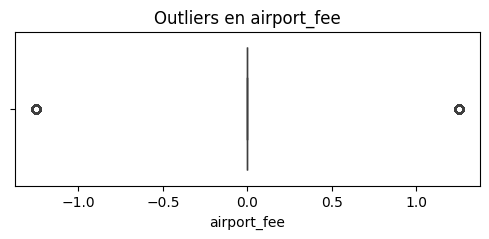

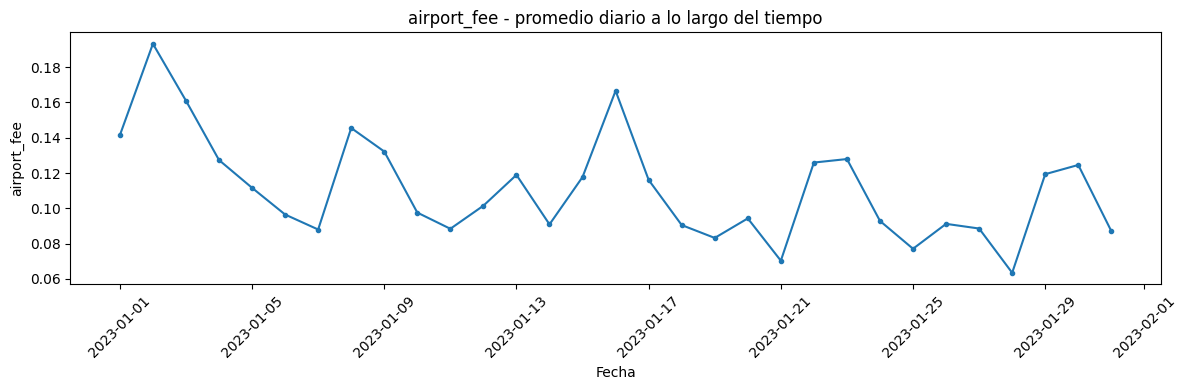

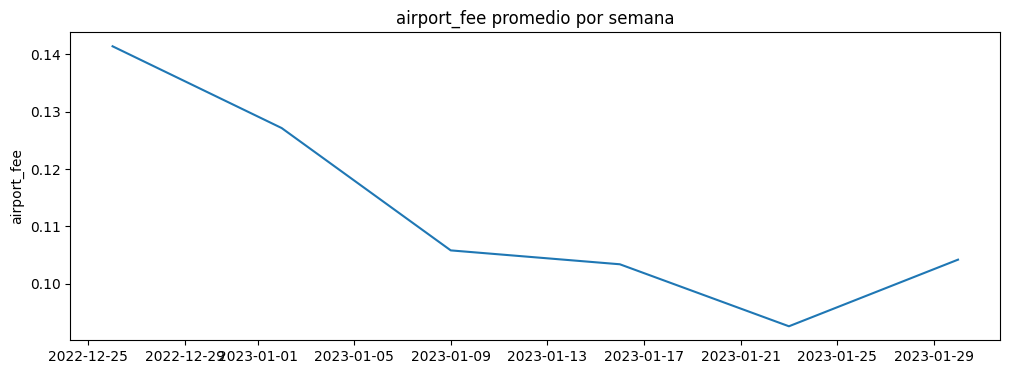

{'skewness': np.float64(2.797951129577879),
 'sesgo': 'muy sesgada',
 'num_outliers': 264391,
 'porcentaje_outliers': 8.829568171328841}

In [64]:
col_name = 'airport_fee'

info = analyze_numeric_variable_spark(ds_filtered_dates, col_name, col_fecha)

Distribución muy sesgada, menos del 10% de outliers y relación temporal moderada.

Aquí acaba el estudio de la capa Bronze. El dataframe modificado con el filtrado de fechas no se va a guardar, ya que en la capa Silver se estudiarán con más detalle las fechas que se salen del período de tiempo de esta serie de datos.

In [65]:
# limpia la memoria
if 'ds' in locals():
    ds.unpersist()
if 'ds_filtered_dates' in locals():
    ds_filtered_dates.unpersist()